# 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
import re
import scipy
import nltk
import pickle
import math
import matplotlib.pyplot as plt
import lightgbm as lgb
import tensorflow as tf
from nltk.stem import WordNetLemmatizer 
from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from scipy.sparse import hstack
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer() 
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# This dataset is generated after getting the train, test and final_test datasets prepped up
# Please do not run this cell if the dataset isn't preprocessed
!cp /content/drive/My\ Drive/mercari\ data/dataset_1.pkl /content

In [ ]:
#Downloading the stopwords for text preprocessing
# https://gist.github.com/sebleier/554280#gistcomment-3431590
#!wget https://gist.githubusercontent.com/ZohebAbai/513218c3468130eacff6481f424e4e64/raw/b70776f341a148293ff277afa0d0302c8c38f7e2/gist_stopwords.txt

#Getting the twitter based word vectors since it will be very much appropriate to use in this case study.
#!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
#!unzip glove.twitter.27B.zip
#!wget http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
#!unzip glove.840B.300d.zip

!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2020-12-02 10:46:41--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.29MB/s    in 6m 29s  

2020-12-02 10:53:11 (2.11 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


# 2. Getting the Categorical features prepped up

## 2.1. Brands

*First of all let's do the missing value imputation for brands as done in EDA.*

In [2]:
#Importing the train dataset
train = pd.read_csv("/content/drive/My Drive/mercari data/train.csv")
del train['Unnamed: 0']
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [3]:
train.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')

In [4]:
#Splitting the data into train and test
train, test = train_test_split(train, shuffle=True, test_size=0.25)

In [5]:
#Printing the number of missing values in the train data
#42.69%
train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          4715
brand_name           474878
price                     0
shipping                  0
item_description          1
dtype: int64

In [6]:
#Printing the number of missing values in the test data
# 42.62%
test.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          1612
brand_name           157804
price                     0
shipping                  0
item_description          3
dtype: int64

In [7]:
#Printing the shape of train data
train.shape

(1111901, 8)

In [8]:
#Printing the shape of test data
test.shape

(370634, 8)

In [9]:
# Importing the test data whose result is to be submitted on kaggle
final_test = pd.read_csv("/content/drive/My Drive/mercari data/test_stg2.csv")
del final_test['Unnamed: 0']
final_test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [10]:
#Printing the number of missing values in the final_test data
#42.66%
final_test.isnull().sum()

test_id                    0
name                       0
item_condition_id          0
category_name          14833
brand_name           1476490
shipping                   0
item_description           6
dtype: int64

In [11]:
#Printing the shape of final_test data
final_test.shape

(3460725, 7)

Thus in all the datasets (Train , Test, Final_test(final_submission.csv for kaggle)) there are **42.6% of missing values** in the **brands** column.

**Train** : (474703/1111901)\*100 = **42.69%**

**Test** : (157979/370634)\*100 = **42.62%**

**Final test** : (1476490/3460725)\*100 = **42.66%**

*The missing values in the brand column imputation starts from here. For detailed explanation please refer EDA.*

In [12]:
def prep_up(train):
  '''
      This function preprocesses the brands present in the train data
  '''
  
  #====================STEP 1====================

  # Setting the brands in the descending order in the list
  temp = [item for items, c in Counter(list(train['filled_brand_name'])).most_common() for item in [items] * c]

  # intilize a null list
  brands = [] 
 
  # traverse for all elements 
  for x in temp:
    # check if exists in unique_list or not
    if x not in brands:
      brands.append(x)

  #====================STEP 2====================

  # Creating the variable to store brands with more than one word.
  brands_more_than_1_word = [i for i in brands if len(i.split()) > 1]

  #Initializing the dictionary to store the original brand name as keys and the preprocessed versions of them as value in the form of a list
  final_brands_more_than_1_word = {}
  
  #Taking into consideration all special combinations of special chars as possible
  special_chars = ["\'m","n\'t","\'re","\'s","\'d","\'ll","\'t","\'ve"]
  #For every brand in brands more than one word
  for brand in tqdm(brands_more_than_1_word):
    #Initializing a temporary list to append them as a value in the final_brands_more_than_1_word with brands as keys
    brand_values = []
    for specs in special_chars:
      #Checking if those special combinations are present
      if specs in brand:
        #if the combination is present then substitute it white an empty space and append the lowercase version of it to the temporary list brand_values
        temp_brand = re.sub(specs, "", brand)
        brand_values.append(temp_brand.lower())
        #Replace the spaces with empty space as even that could be helpful
        brand_values.append(temp_brand.replace(" ","").lower())
        #If & is present in the brand which had those special combinations above then replace it with "and" and append the lowercase version of it 
        if "&" in brand:
          temp_brand = brand.replace("&","and")
          brand_values.append(temp_brand.lower())
    #If & is present in the brand which didn't have or had those special combinations above then replace it with "and" and append the lowercase version of it
    if "&" in brand:
      temp_brand = brand.replace("&","and")
      brand_values.append(temp_brand.lower())
      # Also append the version which has no spaces in them
      brand_values.append(temp_brand.replace(" ","").lower())
    #Append the lowercase version of the original string
    brand_values.append(brand.lower())
    #Append the lowercase version of the original string without whitespaces
    brand_values.append(brand.replace(" ","").lower())
    #Replace the chars other than alphanumeric with empty space and append it
    if brand.lower() != re.sub('[^a-zA-Z0-9 *]', '', brand.lower()):
      temp = " ".join(re.sub('[^a-zA-Z0-9 *]', '', brand.lower()).split())
      brand_values.append(temp)
      #Also append the version which doesn't has whitespaces in temporary list brand_values
      brand_values.append(temp.replace(" ",""))
    #Finally append the key as brand and value has the temporary list to the dictionary
    final_brands_more_than_1_word[brand] = brand_values  

  #Getting rid of some combinnations which is explained in the markdown above
  if "K & W" in final_brands_more_than_1_word.keys():
    del final_brands_more_than_1_word["K & W"][4:]
  if "% Pure" in final_brands_more_than_1_word.keys():
    del final_brands_more_than_1_word["% Pure"][2:]

  #====================STEP 3====================

  #Creating the variable to store brands with one word.
  brands_with_1_word = [i for i in brands if len(i.split()) == 1]
  temp_brands_with_1_word = []
  
  # Initializing list which consists of brands with one word but with frequencies less than 10 in the dataset.
  brands_with_1_word_junk = []
  for i in tqdm(range(len(brands_with_1_word))):
    if list(train['filled_brand_name']).count(brands_with_1_word[i]) > 10:
      temp_brands_with_1_word.append(brands_with_1_word[i])
    else:
      brands_with_1_word_junk.append(brands_with_1_word[i])
  
  #Recreating the variable to store brands with one word but with frequencies less than 10 in the dataset..
  brands_with_1_word = temp_brands_with_1_word
  #Removing NA as it is of no use
  brands_with_1_word.remove('NA')
  
  # Creating a dictionary same as above to append the keys as brands and values as lists of the preprocessed versions of those brands
  final_brands_with_1_word = {}
  # Creating a to append the keys as brands and values as lists of the derived verions of "brands with one word" with more thn one word.
  final_brands_with_1_word_extra = {}
  for brand in tqdm(brands_with_1_word):
    #Checking if the length of the brand is above 2 except for the brand 'LG'
    if len(brand)>2 or brand=="LG":
      #Initializing a temporary list just like in Step 2
      brand_values = []
      # This loop does the same thing as done in step 2
      for specs in special_chars:
        if specs in brand:
          temp_brand = re.sub(specs, "", brand)
          brand_values.append(temp_brand.lower())
      if brand=='Style&co.':
        temp_brand = re.sub("\s*&\s*"," and ", brand)
        final_brands_with_1_word_extra[brand] = [temp_brand.lower(), temp_brand.replace('.','').lower()]
      brand_values.append(brand.lower())
      # Even in this case it's the same as step 2 except to check whether the length of the string after removal of special characters in more than 2 or not
      if brand.lower() != re.sub('[^a-zA-Z0-9 *]', '', brand.lower()) and (len(re.sub('[^a-zA-Z0-9 *]', '', brand.lower()))>2 or any(i.isdigit() for i in re.sub('[^a-zA-Z0-9 *]', '', brand.lower()))):
        brand_values.append(" ".join(re.sub('[^a-zA-Z0-9 *]', '', brand.lower()).split()))
      punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~©®™'''
      no_punct = ""
      # Even this has the same functuality as mentioned in step 2 except for that if there are words more than 1 then append it to final_brands_with_1_word_extra
      for char in brand:
        if char not in punctuations:
          no_punct = no_punct + char
        else:
          no_punct = no_punct + " "
      if len(no_punct.split())>1 and len(" ".join(no_punct.split()))>3:
        if brand != 'Style&co.':
          final_brands_with_1_word_extra[brand] = [(" ".join(no_punct.split())).lower()]
      #Finally key=brand and value=temporary list with all the preprocessed versions of that brand
      final_brands_with_1_word[brand] = brand_values

  #====================STEP 4====================

  # Everything is the same here as that of STEP 3 that's why ignored commenting everything
  # The only difference is that these are the brands with one word and frequencies less than 10.
  final_brands_with_1_word_junk = {}
  final_brands_with_1_word_junk_extra = {}
  for brand in tqdm(brands_with_1_word_junk):
    if len(brand)>2 or brand=="LG":
      brand_values = []
      for specs in special_chars:
        if specs in brand:
          temp_brand = re.sub(specs, "", brand)
          brand_values.append(temp_brand.lower())
      if brand=='Pull&Bear':
        temp_brand = re.sub("\s*&\s*"," and ", brand)
        final_brands_with_1_word_junk_extra[brand] = [temp_brand.lower()]
      brand_values.append(brand.lower())
      if brand.lower() != re.sub('[^a-zA-Z0-9 *]', '', brand.lower()) and (len(re.sub('[^a-zA-Z0-9 *]', '', brand.lower()))>2 or any(i.isdigit() for i in re.sub('[^a-zA-Z0-9 *]', '', brand.lower()))):
        brand_values.append(" ".join(re.sub('[^a-zA-Z0-9 *]', '', brand.lower()).split()))
      punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~©®™'''
      no_punct = ""
      for char in brand:
        if char not in punctuations:
          no_punct = no_punct + char
        else:
          no_punct = no_punct + " "
      if len(no_punct.split())>1 and len(" ".join(no_punct.split()))>3:
        if brand != 'Pull&Bear':
          final_brands_with_1_word_junk_extra[brand] = [(" ".join(no_punct.split())).lower()]
      final_brands_with_1_word_junk[brand] = brand_values
  final_brands_with_1_word_junk['All'] = final_brands_with_1_word['All']
  #Getting rid of "All" key as it created unnecessary imputations
  if 'All' in final_brands_with_1_word.keys():
    del final_brands_with_1_word['All'] 
  if 'AT&T' in final_brands_with_1_word_junk_extra.keys():
    del final_brands_with_1_word_junk_extra['AT&T']
  if 'AT&T' in final_brands_with_1_word_junk.keys():
    del final_brands_with_1_word_junk['AT&T'][1]
  # I realized that "AND", "Ask" and "All" resulted in unnecessary imputations and so I got rid of them.
  # Since their frequencies are less than 10 as well, it's better to get rid of them.
  if "AND" in final_brands_with_1_word_junk.keys():
    del final_brands_with_1_word_junk["AND"]
  if "Ask" in final_brands_with_1_word_junk.keys():
    del final_brands_with_1_word_junk["Ask"]
  if "All" in final_brands_with_1_word_junk.keys():
    del final_brands_with_1_word_junk["All"]

  #====================STEP 5====================
  print("\n\nNumber of brands with more than one word : ",len(brands_more_than_1_word))
  count_final_brands_more_than_1_word = 0
  for k,v in final_brands_more_than_1_word.items():
    count_final_brands_more_than_1_word = count_final_brands_more_than_1_word + len(v)
  print("Number of all preprocessed brands with more than 1 word : ", count_final_brands_more_than_1_word)

  print("\n\nNumber of brands with one word : ",len(brands_with_1_word))
  count_final_brands_with_1_word = 0
  for k,v in final_brands_with_1_word.items():
    count_final_brands_with_1_word = count_final_brands_with_1_word + len(v)
  print("Number of all preprocessed brands with 1 word : ", count_final_brands_with_1_word)

  count_final_brands_with_1_word_extra = 0
  for k,v in final_brands_with_1_word_extra.items():
    count_final_brands_with_1_word_extra = count_final_brands_with_1_word_extra + len(v)
  print("Number of all preprocessed brands generated from brands with 1 word : ", count_final_brands_with_1_word_extra)

  print("\n\nNumber of brands with one word with frequencies below 10 : ",len(brands_with_1_word_junk))
  count_final_brands_with_1_word_junk = 0
  for k,v in final_brands_with_1_word_junk.items():
    count_final_brands_with_1_word_junk = count_final_brands_with_1_word_junk + len(v)
  print("Number of all preprocessed brands with 1 word with frequencies below 10 : ", count_final_brands_with_1_word_junk)

  count_final_brands_with_1_word_junk_extra = 0
  for k,v in final_brands_with_1_word_junk_extra.items():
    count_final_brands_with_1_word_junk_extra = count_final_brands_with_1_word_junk_extra + len(v)
  print("Number of all preprocessed brands generated from brands with 1 word with frequencies below 10 : ", count_final_brands_with_1_word_junk_extra)

  total = count_final_brands_with_1_word+count_final_brands_more_than_1_word+count_final_brands_with_1_word_extra+count_final_brands_with_1_word_junk+count_final_brands_with_1_word_junk_extra
  print("\nIn all, there are {} preprocessed brands to deal with.\n".format(total))

  # STEP 9
  return final_brands_more_than_1_word, final_brands_with_1_word, final_brands_with_1_word_extra, final_brands_with_1_word_junk, final_brands_with_1_word_junk_extra

In [13]:
# Filling the missing values in all the datasets temporarily with the word 'NA'
train['filled_brand_name'] = train['brand_name'].fillna("NA")
test['filled_brand_name'] = test['brand_name'].fillna("NA")
final_test['filled_brand_name'] = final_test['brand_name'].fillna("NA")

# Getting the brands only from the train dataset to avoid data leakage during modelling
brands_more_than_1_word, brands_with_1_word, brands_with_1_word_extra, brands_with_1_word_junk, brands_with_1_word_junk_extra = prep_up(train)

100%|██████████| 1414/1414 [00:00<00:00, 186495.58it/s]



Number of brands with more than one word :  2232
Number of all preprocessed brands with more than 1 word :  5357


Number of brands with one word :  815
Number of all preprocessed brands with 1 word :  871
Number of all preprocessed brands generated from brands with 1 word :  42


Number of brands with one word with frequencies below 10 :  1414
Number of all preprocessed brands with 1 word with frequencies below 10 :  1499
Number of all preprocessed brands generated from brands with 1 word with frequencies below 10 :  64

In all, there are 7833 preprocessed brands to deal with.



In [14]:
# I have merged the brands_more_than_1_word and brands_with_1_word_extra(derived from brands with 1 word) to make the searching more fast
merge_brands_more_than_1_word = {}

for k,v in brands_more_than_1_word.items():
  merge_brands_more_than_1_word[k] = v

for k,v in brands_with_1_word_extra.items():
  merge_brands_more_than_1_word[k] = v

In [15]:
pickle.dump((merge_brands_more_than_1_word,
             brands_with_1_word, 
             brands_with_1_word_junk_extra, 
             brands_with_1_word_junk),open('/content/drive/My Drive/mercari data/brands.pkl','wb'))

In [ ]:
def text(df):
  '''
  This function preprocesses the textual data present in the dataset
  '''
  
  df["item_description"] = df["item_description"].fillna(value="No description yet.")
  all_text = list(df['name']+" "+df['item_description'])

  #define punctuation
  all_text_no_punc = []
  punctuations = '!()-[]{};:\'\"\,<>./?@#$%^&*_~©®™'
  for i in tqdm(range(len(all_text))):
    no_punct = ""
    for char in all_text[i]:
      if char not in punctuations:
        no_punct = no_punct + char
      else:
        no_punct = no_punct + " "
    #Appending the text version with no punctuations
    all_text_no_punc.append((" ".join(no_punct.split())).lower())
    #Appending the text version with punctuations
    all_text[i] = all_text[i].lower()

  # STEP 8
  print("\nSample text with no punctuation : ",all_text_no_punc[1])
  print("Sample text with punctuation : ",all_text[1])

  return all_text, all_text_no_punc

In [ ]:
print("\n\n TEXT PREPROCESS TRAIN DATA : \n")
all_text_train, all_text_no_punc_train = text(train)
print("\n\n TEXT PREPROCESS TEST DATA : \n")
all_text_test, all_text_no_punc_test = text(test)
print("\n\n TEXT PREPROCESS FINAL_TEST DATA : \n")
all_text_final_test, all_text_no_punc_final_test = text(final_test)



 TEXT PREPROCESS TRAIN DATA : 



100%|██████████| 1111901/1111901 [00:22<00:00, 48826.82it/s]



Sample text with no punctuation :  baby girl headbands it s new never used
Sample text with punctuation :  baby girl headbands it's new never used


 TEXT PREPROCESS TEST DATA : 



100%|██████████| 370634/370634 [00:07<00:00, 49226.29it/s]



Sample text with no punctuation :  betsey johnson 3 pr earrings lucky new betsey johnson lucky brand free shipping new on cards comes with cute jewelry pouches ships out same day
Sample text with punctuation :  betsey johnson 3 pr earrings, lucky, new betsey johnson lucky brand free shipping new on cards comes with cute jewelry pouches ships out same day


 TEXT PREPROCESS FINAL_TEST DATA : 



100%|██████████| 3460725/3460725 [01:11<00:00, 48423.50it/s]


Sample text with no punctuation :  25 pcs new 7 5 x12 kraft bubble mailers 25 pcs new 7 5 x12 kraft bubble mailers lined with bubble wrap for protection self sealing peel and seal adhesive keeps contents secure and tamper proof durable and lightweight kraft material helps save on postage approved by ups fedex and usps
Sample text with punctuation :  25 pcs new 7.5"x12" kraft bubble mailers 25 pcs new 7.5"x12" kraft bubble mailers lined with bubble wrap for protection self sealing (peel-and-seal), adhesive keeps contents secure and tamper proof durable and lightweight kraft material helps save on postage approved by ups, fedex, and usps.


In [ ]:
def missing_values_compute(train_brand_name, all_text, all_text_no_punc):
  '''
      This function imputes the missing values for brands in the given dataset
  '''

  # **********IMPUTATION STARTS HERE**********
  
  for counter in tqdm(range(len(train_brand_name))):
    #====================================
    # STEP 1
    #====================================

    # merge_brands_more_than_1_word --- text with punctuation
    if train_brand_name[counter] == "NA":
      count = 0
      for brand, preprocessed_brands in merge_brands_more_than_1_word.items():
        for preprocessed_brand in preprocessed_brands:
          if preprocessed_brand in all_text[counter]:
            train_brand_name[counter] = brand
            count = 1
            break
        if count>0:
          break
        
    if train_brand_name[counter] != "NA":
      continue

    # merge_brands_more_than_1_word --- text with no punctuation
    if train_brand_name[counter] == "NA":
      count = 0
      for brand, preprocessed_brands in merge_brands_more_than_1_word.items():
        for preprocessed_brand in preprocessed_brands:
          if preprocessed_brand in all_text_no_punc[counter]:
            train_brand_name[counter] = brand
            count = 1
            break
        if count>0:
          break

    if train_brand_name[counter] != "NA":
      continue

    #====================================
    # STEP 2
    #====================================

    # brands_with_1_word --- text with punctuation
    if train_brand_name[counter] == "NA":
      count = 0
      for brand, preprocessed_brands in brands_with_1_word.items():
        for preprocessed_brand in preprocessed_brands:
          if preprocessed_brand in all_text[counter].split():
            train_brand_name[counter] = brand
            count = 1
            break
        if count>0:
          break

    if train_brand_name[counter] != "NA":
      continue

    #brands_with_1_word --- text with no punctuation
    if train_brand_name[counter] == "NA":
      count = 0
      for brand, preprocessed_brands in brands_with_1_word.items():
        for preprocessed_brand in preprocessed_brands:
          if preprocessed_brand in all_text_no_punc[counter].split():
            train_brand_name[counter] = brand
            count = 1
            break
        if count>0:
          break

    if train_brand_name[counter] != "NA":
      continue

    #====================================
    # STEP 3
    #====================================

    #brands_with_1_word_junk_extra --- text with punctuation
    if train_brand_name[counter] == "NA":
      count = 0
      for brand, preprocessed_brands in brands_with_1_word_junk_extra.items():
        for preprocessed_brand in preprocessed_brands:
          if preprocessed_brand in all_text[counter]:
            train_brand_name[counter] = brand
            count = 1
            break
        if count>0:
          break
        
    if train_brand_name[counter] != "NA":
      continue

    # brands_with_1_word_junk_extra --- text with no punctuation
    if train_brand_name[counter] == "NA":
      count = 0
      for brand, preprocessed_brands in brands_with_1_word_junk_extra.items():
        for preprocessed_brand in preprocessed_brands:
          if preprocessed_brand in all_text_no_punc[counter]:
            train_brand_name[counter] = brand
            count = 1
            break
        if count>0:
          break

    if train_brand_name[counter] != "NA":
      continue

    #====================================
    # STEP 4
    #====================================

    # brands_with_1_word_junk --- text with punctuation
    if train_brand_name[counter] == "NA":
      count = 0
      for brand, preprocessed_brands in brands_with_1_word_junk.items():
        for preprocessed_brand in preprocessed_brands:
          if preprocessed_brand in all_text[counter].split():
            train_brand_name[counter] = brand
            count = 1
            break
        if count>0:
          break

    if train_brand_name[counter] != "NA":
      continue

    #brands_with_1_word_junk --- text with no punctuation
    if train_brand_name[counter] == "NA":
      count = 0
      for brand, preprocessed_brands in brands_with_1_word_junk.items():
        for preprocessed_brand in preprocessed_brands:
          if preprocessed_brand in all_text_no_punc[counter].split():
            train_brand_name[counter] = brand
            count = 1
            break
        if count>0:
          break

  return train_brand_name

Thus as we can see the **number of missing values in all the datasets** just remain around **16.3%** which is really a good thing as it keeps all the datasets **balanced**.

Missing values in **train** = (181,759/1,111,901)\*100 = **16.3467%**

Missing values in **test** = (60,522/370,634)\*100 = **16.3293%**

Missing values in **final_test** = (565,090/3,460,725)\*100 = **16.3286%**

In [ ]:
brand_name_column = list(train['filled_brand_name'])
brand_name = missing_values_compute(brand_name_column, all_text_train, all_text_no_punc_train)
# Printing the number of NA yet present have imputation
print("\n\nNumber of null values in train : ",list(brand_name).count("NA"))
#Creating a new column with the imputed brands
train['filled_brand_name'] = brand_name

100%|██████████| 1111901/1111901 [50:50<00:00, 364.54it/s]



Number of null values in train :  181759


In [ ]:
brand_name_column = list(test['filled_brand_name'])
brand_name = missing_values_compute(brand_name_column, all_text_test, all_text_no_punc_test)
# Printing the number of NA yet present have imputation
print("\n\nNumber of null values in test : ",list(brand_name).count("NA"))
#Creating a new column with the imputed brands
test['filled_brand_name'] = brand_name

100%|██████████| 370634/370634 [16:52<00:00, 365.94it/s]



Number of null values in test :  60522


In [ ]:
brand_name_column = list(final_test['filled_brand_name'])
brand_name = missing_values_compute(brand_name_column, all_text_final_test, all_text_no_punc_final_test)
# Printing the number of NA yet present have imputation
print("\n\nNumber of null values in final_test : ",list(brand_name).count("NA"))
#Creating a new column with the imputed brands
final_test['filled_brand_name'] = brand_name

100%|██████████| 3460725/3460725 [2:37:42<00:00, 365.73it/s]




Number of null values in final_test :  565090


In [ ]:
train.head(60)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,filled_brand_name
439347,439347,Lululemon Black Tank Top,2,Women/Athletic Apparel/Shirts & Tops,Lululemon,26.0,0,Worn only a few times. On the back it has a se...,Lululemon
519732,519732,Baby Girl Headbands,1,Kids/Girls 0-24 Mos/Accessories,NaN,9.0,1,It's new never used,NA
1284213,1284213,2 Smith and Wesson sticker,1,Handmade/Paper Goods/Sticker,NaN,3.0,1,•one 5 inch diameter smith and Wesson sticker ...,NA
770464,770464,New dog picture frame,1,Home/Home Décor/Photo Albums & Frames,NaN,10.0,0,Good dog picture frame holds 4x6 photo.. new n...,NA
720025,720025,Frankenstein by Mary Shelley,4,Other/Books/Literature & Fiction,NaN,5.0,1,This highlighted and annotated book took hours...,NA
911970,911970,Toddler girl sandals,1,Kids/Girls 2T-5T/Shoes,NaN,8.0,0,New with tags Size 8,NA
511704,511704,M@k Earrings,1,Women/Jewelry/Earrings,Michael Kors,21.0,0,Rose gold M@K earrings with diamonds around he...,Michael Kors
616539,616539,Ombré cardigan,3,Women/Sweaters/Cardigan,NaN,8.0,0,ombré cardigan button up size large has a few ...,NA
1343919,1343919,(40pcs) VINTAGE Little Tikes Dollhouse,3,Kids/Toys/Baby & Toddler Toys,Little Tikes,135.0,1,[40 accessories included] Original blue roof d...,Little Tikes
493274,493274,2012 SI/ Prizm Harper GMA10 for maluegjr,1,Vintage & Collectibles/Trading Cards/Sports,MLB,30.0,1,2012 Sports Illustrated for Kids And 2012 Priz...,MLB


In [ ]:
train.tail(60)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,filled_brand_name
338467,338467,Disney Princess Flip Flops,2,Kids/Girls 2T-5T/Shoes,Disney,8.0,0,Never worn Disney Princess Flip Flops size 9/10,Disney
700339,700339,Space Galaxy Astronaut Socks,1,Women/Athletic Apparel/Socks,NaN,8.0,1,Cute cute cute space crew socks!! Black with p...,Galaxy
1399318,1399318,Baby blankets,3,Home/Bedding/Blankets & Throws,NaN,11.0,0,7 baby girl blankets! All in really good condi...,NA
726855,726855,"GAP Striped midi skirt, L",3,Women/Skirts/Other,Gap,9.0,0,"GAP Striped midi skirt, L For reference, I am ...",Gap
1352738,1352738,FS! Caudalie beauty elixir 1oz,1,Beauty/Skin Care/Face,NaN,13.0,1,caudalie beauty elixir spray 1oz NEW！ 1 for 13...,Caudalie
30896,30896,Victoria's Secret Sports Bra,1,Women/Athletic Apparel/Sports Bras,Victoria's Secret,14.0,1,Size medium. Green & black. Medium support. Ne...,Victoria's Secret
1192602,1192602,Crew socks,2,Women/Athletic Apparel/Socks,American Eagle,4.0,1,Perfect for summer!,American Eagle
456590,456590,VANS SK8-HI REISSUE (DENIM C&L),1,Men/Shoes/Fashion Sneakers,VANS,38.0,0,VANS - DENIM AND LEATHER - ROPE LACES,VANS
1399798,1399798,Vera Bradley messenger Island blooms,2,Women/Women's Handbags/Messenger & Crossbody,Vera Bradley,21.0,0,Retired print excellent condition No stains sn...,Vera Bradley
702968,702968,"18k GOLD PLATED 26"" CHAIN NECKLACE NEW",2,Men/Men's Accessories/Other,NaN,22.0,1,"18k GOLD PLATED 26"" CHAIN NECKLACE NEW GOLD P ...",NA


In [ ]:
test.head(60)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,filled_brand_name
1456657,1456657,FREESHIP - BBW lotion lot,1,Beauty/Skin Care/Body,Bath & Body Works,18.0,1,Retail value [rm] plus shipping. All are new &...,Bath & Body Works
602352,602352,"Betsey Johnson 3 pr earrings, Lucky, new",2,Women/Jewelry/Earrings,Betsey Johnson,8.0,1,Betsey Johnson Lucky brand Free shipping New o...,Betsey Johnson
492499,492499,Pediped Couture 6-12 gold ballet flats,4,Kids/Girls 0-24 Mos/Shoes,NaN,13.0,1,Absolutely beautiful gold reptile print shoes ...,NA
363185,363185,PINK Black Backpack,1,Women/Women's Handbags/Backpack Style,PINK,31.0,0,An essential bag that’s super cute with plenty...,PINK
1474153,1474153,3T boys under Armour orange shirt NEW,1,Kids/Boys 2T-5T/Tops & T-Shirts,NaN,12.0,1,No description yet,Under Armour
459417,459417,Belly Button Piercing Kit,1,Women/Jewelry/Rings,NaN,8.0,0,"Includes one 14G belly Button ring, one 12G EO...",Ring
483258,483258,Lularoe xxs blue striped maxi skirt,3,Women/Skirts/Maxi,NaN,26.0,0,Euc xxs lularoe maxi skirt dress. Worn once an...,LuLaRoe
46331,46331,Call of Duty Black Ops III,1,Electronics/Video Games & Consoles/Games,Sony,14.0,0,No description yet,Sony
202528,202528,Babyganics Bubble Sunscreen Sanitizer,1,Kids/Bathing & Skin Care/Skin Care,NaN,26.0,0,For sale this Babyganics Bundle. 1x Bottle -Bu...,BabyGanics
259316,259316,21 Jump Street & 22 Jump Street DVD,2,Electronics/Media/DVD,NaN,6.0,1,Although they made their way through high scho...,ART


In [ ]:
test.tail(60)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,filled_brand_name
239544,239544,Choker,1,Women/Jewelry/Necklaces,NaN,4.0,1,It's new never used,NA
619689,619689,New 4 pcs boho ring set,1,Women/Jewelry/Rings,NaN,9.0,0,Bundle to get more with only one shipping fee....,Ring
1430495,1430495,Wonderful Dreams Pallet By Sephora,3,Beauty/Makeup/Makeup Palettes,Sephora,11.0,0,-Very lightly used - very pigmented eyeshadows...,Sephora
640921,640921,Bundle of Baby boys casual shoes,3,Kids/Boys 0-24 Mos/Shoes,NaN,8.0,0,Little boys size 4. In fantastic condition. Co...,CLEAN
664940,664940,Rare pocketbac holder bundle BBW,2,Beauty/Skin Care/Body,Bath & Body Works,7.0,1,Super cute Dalmatian dog and skunk with rose! ...,Bath & Body Works
300434,300434,Request cheer bows,1,Women/Women's Accessories/Hair Accessories,NaN,39.0,0,Full glitter with rhinestones cheer bows,Request
796996,796996,4 Brandy Melville Stickers,2,Handmade/Paper Goods/Sticker,NaN,4.0,1,chosen at random! :),Brandy Melville
243458,243458,CZ square cut stud post earrings,1,Women/Jewelry/Earrings,NaN,10.0,1,Beautiful elegant everyday square cut stud ear...,Square
523404,523404,Tarte bundle for kmclaughlin,3,Beauty/Makeup/Face,Tarte,30.0,1,Tarte Empowered hybrid gel foundation in light...,Tarte
903006,903006,Black jumpsuit,1,Women/Dresses/Full-Length,NaN,19.0,0,"Nwt size s, but fits like an xs a bit snug on ...",NA


In [ ]:
final_test.head(60)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,filled_brand_name
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,Ring
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",NA
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Coach
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...,NA
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...,NA
5,5,iPhone 6 Plus or 6s Plus Vodka pink case,1,"Electronics/Cell Phones & Accessories/Cases, C...",NaN,1,One Absolut Vodka in Pink for iPhone 6 Plus an...,PINK
6,6,Vintage Cameo Pendant & Brooch Pin,3,Women/Jewelry/Necklaces,Vintage,1,Two vintage Cameo pieces. 1. Silver metal Lock...,Vintage
7,7,Rose Gold Stainless Steel Quartz Watch,1,Women/Women's Accessories/Watches,NaN,1,Brand new Price firm No trades Box included wi...,NA
8,8,Daisy Marc Jacobs 3.4oz,3,Beauty/Fragrance/Women,MARC JACOBS,0,Brand new No box 100% authentic Firm price NO ...,MARC JACOBS
9,9,Rose Brushes and Silicone Sponge,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,1,All new. 12 pcs makeup brushes and one Silicon...,NA


In [ ]:
final_test.tail(60)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,filled_brand_name
3460665,3460665,Boppy,3,Kids/Pregnancy & Maternity/Breastfeeding Pillo...,Boppy,0,In great condition,Boppy
3460666,3460666,"Nwt, Barbie Purse!",1,Women/Women's Handbags/Shoulder Bag,NaN,0,"Nwt, pink with black Barbie purse. Chain handl...",PINK
3460667,3460667,05 Quenched Baby Lips,1,Beauty/Makeup/Lips,Maybelline,1,You will receive 1 Baby Lips Moisturizing Lip ...,Maybelline
3460668,3460668,Two NEW 100 pc puzzles,1,Kids/Toys/Puzzles,NaN,1,Two brand new avengers 100 piece puzzles,NA
3460669,3460669,Nike rosches size 8,3,Women/Shoes/Athletic,Nike,0,Never really wear haven't washed yet,Nike
3460670,3460670,(M) Gray LuLaRoe Irma,1,Women/Tops & Blouses/Tunic,NaN,1,Size Medium Brand new with tags and in package...,LuLaRoe
3460671,3460671,Lace front Wig,3,Beauty/Hair Care/Hair Loss Products,NaN,1,Pre-owned lace front Wig....only worn 3 times....,NA
3460672,3460672,Multiple bundles on hold,3,Kids/Toys/Action Figures & Statues,Funko,1,Psp 3001 console Psp games Ps2 games Ps3 games...,Funko
3460673,3460673,PS3 Grand Theft Auto 5,2,Electronics/Video Games & Consoles/Games,Sony,1,Playstation 3 complete game in excellent condi...,Sony
3460674,3460674,Snow White Funko Pop Retired HTF Disney,1,Vintage & Collectibles/Antique/Collectibles,NaN,1,Great condition,Disney


In [ ]:
# Saving the imputed version of csv 
train.to_csv('/content/drive/My Drive/mercari data/train_1.csv') 
test.to_csv('/content/drive/My Drive/mercari data/test_1.csv')
final_test.to_csv('/content/drive/My Drive/mercari data/final_test_1.csv')

## 2.2. Categories

Let's now work on filling the **missing values** in the **categories column**.

In [2]:
#Importing the imputed version of the csvs.
train = pd.read_csv("/content/drive/My Drive/mercari data/train_1.csv")
del train['Unnamed: 0']
test = pd.read_csv('/content/drive/My Drive/mercari data/test_1.csv')
del test['Unnamed: 0']
final_test = pd.read_csv('/content/drive/My Drive/mercari data/final_test_1.csv')
del final_test['Unnamed: 0']

In [3]:
train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          4759
brand_name           474417
price                     0
shipping                  0
item_description          0
filled_brand_name    181759
dtype: int64

In [4]:
test.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          1568
brand_name           158265
price                     0
shipping                  0
item_description          0
filled_brand_name     60522
dtype: int64

In [5]:
final_test.isnull().sum()

test_id                    0
name                       0
item_condition_id          0
category_name          14833
brand_name           1476490
shipping                   0
item_description           0
filled_brand_name     565090
dtype: int64

In [6]:
# Replacing the NULL values with a string
train['category_name'].fillna(value="NA",inplace=True)
test['category_name'].fillna(value="NA",inplace=True)
final_test['category_name'].fillna(value="NA",inplace=True)

I have considered only the **categories** with respect to **Train** data to **avoid data leakage**.

*To understand all the code snippets in this section please refer EDA.*

In [7]:
# There are 3 categories per Category Name in the data.
# The format of the category is : main_category/main_sub_category/sub_category
# So I have created 3 lists to split them with respect to the punctuation '/'.

# This is the code to create lists of main and its sub-categories

train_categories = list(train['category_name'])
train_main_category = []
train_main_sub_category = []
train_sub_category = []

for i in train_categories:
  if not i=="NA":
    temp = i.split('/')
    train_main_category.append(temp[0])
    train_main_sub_category.append(temp[1])
    train_sub_category.append(temp[2])
  else:
    train_main_category.append("NA")
    train_main_sub_category.append("NA")
    train_sub_category.append("NA")

test_categories = list(test['category_name'])
test_main_category = []
test_main_sub_category = []
test_sub_category = []

for i in test_categories:
  if not i=="NA":
    temp = i.split('/')
    test_main_category.append(temp[0])
    test_main_sub_category.append(temp[1])
    test_sub_category.append(temp[2])
  else:
    test_main_category.append("NA")
    test_main_sub_category.append("NA")
    test_sub_category.append("NA")

final_test_categories = list(final_test['category_name'])
final_test_main_category = []
final_test_main_sub_category = []
final_test_sub_category = []

for i in final_test_categories:
  if not i=="NA":
    temp = i.split('/')
    final_test_main_category.append(temp[0])
    final_test_main_sub_category.append(temp[1])
    final_test_sub_category.append(temp[2])
  else:
    final_test_main_category.append("NA")
    final_test_main_sub_category.append("NA")
    final_test_sub_category.append("NA")

In [8]:
#Code to get the set of unique category types
train_cats = list(train['category_name'])
unique_cats = set(train_cats)
unique_cats = list(unique_cats)

print("Number of unique categories along with their main sub-categories and sub-categories :   {}".format(len(unique_cats)))

Number of unique categories along with their main sub-categories and sub-categories :   1262


### 2.2.1. Main Categories

#### 2.2.1.1. Train

In [9]:
# This code creates a dictionary where key represents the actual category and the value represents preprocessed versions of it in the form of a list.

#Getting unique categories 
temp_unique_categories = dict(Counter(train_main_category))
unique_categories = {}

#for each key in unique categories
for k,v in temp_unique_categories.items():
  # This step is to et rid of NA category since it isn't useful
  if k!= 'NA':
    #if there's only one word in the category the append the lowercase version of it
    if len(k.split())<2:
      unique_categories[k] = [k.lower()]
    else:
      temp_cats = []
      for i in k.split():
        # Replace "&" with "and" are create useful versions just as it had been done while preprocessing brands.
        if i != '&':
          temp_cats.append(i.lower())
      temp_cats.append(k.replace(" ",""))
      temp_cats.append(re.sub("\s*&\s*"," and ",k))
      unique_categories[k] = temp_cats

unique_categories

{'Beauty': ['beauty'],
 'Electronics': ['electronics'],
 'Handmade': ['handmade'],
 'Home': ['home'],
 'Kids': ['kids'],
 'Men': ['men'],
 'Other': ['other'],
 'Sports & Outdoors': ['sports',
  'outdoors',
  'Sports&Outdoors',
  'Sports and Outdoors'],
 'Vintage & Collectibles': ['vintage',
  'collectibles',
  'Vintage&Collectibles',
  'Vintage and Collectibles'],
 'Women': ['women']}

In [10]:
pickle.dump((unique_categories),open('/content/drive/My Drive/mercari data/main_cats.pkl','wb'))

In [11]:
# Prepping the text data by merging the item name with item desription and then converting it to lowercase
train["item_description"] = train["item_description"].fillna(value="No description yet.")
all_text = train['name']+" "+train['item_description']
for i in range(len(all_text)):
  all_text[i] = all_text[i].lower()

In [12]:
#Missing value imputation of main categories starts here
for i in tqdm(range(len(train_main_category))):
  if train_main_category[i] == 'NA':
    count = 0
    for k,v in unique_categories.items():
      for cat in v:
        if cat in all_text[i]:
          train_main_category[i] = k
          count = 1
          break
      if count>0:
        break

100%|██████████| 1111901/1111901 [00:00<00:00, 1578821.49it/s]


In [13]:
print("Number of NA values in Main categories of Train data is",train_main_category.count("NA"))

Number of NA values in Main categories of Train data is 3852


#### 2.2.1.2. Test

In [14]:
# Prepping the text data by merging the item name with item desription and then converting it to lowercase
test["item_description"] = test["item_description"].fillna(value="No description yet.")
all_text = test['name']+" "+test['item_description']
for i in range(len(all_text)):
  all_text[i] = all_text[i].lower()

In [15]:
#Missing value imputation of main categories starts here
for i in tqdm(range(len(test_main_category))):
  if test_main_category[i] == 'NA':
    count = 0
    for k,v in unique_categories.items():
      for cat in v:
        if cat in all_text[i]:
          test_main_category[i] = k
          count = 1
          break
      if count>0:
        break

100%|██████████| 370634/370634 [00:00<00:00, 1486583.58it/s]


In [16]:
print("Number of NA values in Main categories of Test data is",test_main_category.count("NA"))

Number of NA values in Main categories of Test data is 1270


#### 2.2.1.3. Final Test

In [17]:
# Prepping the text data by merging the item name with item desription and then converting it to lowercase
final_test["item_description"] = final_test["item_description"].fillna(value="No description yet.")
all_text = final_test['name']+" "+final_test['item_description']
for i in range(len(all_text)):
  all_text[i] = all_text[i].lower()

In [18]:
#Missing value imputation of main categories starts here
for i in tqdm(range(len(final_test_main_category))):
  if final_test_main_category[i] == 'NA':
    count = 0
    for k,v in unique_categories.items():
      for cat in v:
        if cat in all_text[i]:
          final_test_main_category[i] = k
          count = 1
          break
      if count>0:
        break

100%|██████████| 3460725/3460725 [00:02<00:00, 1710511.97it/s]


In [19]:
print("Number of NA values in Main categories of Final Test data is",final_test_main_category.count("NA"))

Number of NA values in Main categories of Final Test data is 11941


### 2.2.2. Main Sub-Categories

#### 2.2.2.1. Train

In [20]:
# This code creates a dictionary where key represents the actual category and the value represents preprocessed versions of it in the form of a list.
# Since it's the same code from above as the Main categories apart from some changes based on observations, I have ignored commenting out different steps.
temp_unique_categories = dict(Counter(train_main_sub_category))
unique_categories = {}
for k,v in temp_unique_categories.items():
  if k!= 'NA':
    if len(k.split())<2:
      unique_categories[k] = [k.lower()]
    else:
      temp_cats = []
      for i in k.split():
        if i != '&' and i != 'and' and i != 'And':
          temp_cats.append(i.lower())
        else:
          temp_cats.append(k)
      temp_cats.append(k.replace(" ",""))
      temp_cats.append(re.sub("\s*&\s*"," and ",k))
      unique_categories[k] = temp_cats

unique_categories

{'Accessories': ['accessories'],
 'Antique': ['antique'],
 'Apparel': ['apparel'],
 'Art': ['art'],
 'Artwork': ['artwork'],
 'Athletic Apparel': ['athletic',
  'apparel',
  'AthleticApparel',
  'Athletic Apparel'],
 'Automotive': ['automotive'],
 'Bags and Purses': ['bags',
  'Bags and Purses',
  'purses',
  'BagsandPurses',
  'Bags and Purses'],
 'Bath': ['bath'],
 'Bath & Body': ['bath', 'Bath & Body', 'body', 'Bath&Body', 'Bath and Body'],
 'Bathing & Skin Care': ['bathing',
  'Bathing & Skin Care',
  'skin',
  'care',
  'Bathing&SkinCare',
  'Bathing and Skin Care'],
 'Bedding': ['bedding'],
 'Blazers & Sport Coats': ['blazers',
  'Blazers & Sport Coats',
  'sport',
  'coats',
  'Blazers&SportCoats',
  'Blazers and Sport Coats'],
 'Book': ['book'],
 'Books': ['books'],
 'Books and Zines': ['books',
  'Books and Zines',
  'zines',
  'BooksandZines',
  'Books and Zines'],
 'Boys (4+)': ['boys', '(4+)', 'Boys(4+)', 'Boys (4+)'],
 'Boys 0-24 Mos': ['boys', '0-24', 'mos', 'Boys0-24Mos'

In [21]:
pickle.dump((unique_categories),open('/content/drive/My Drive/mercari data/main_sub_cats.pkl','wb'))

In [22]:
# Prepping the text data by merging the item name with item desription and then converting it to lowercase
all_text = train['name']+" "+train['item_description']
for i in range(len(all_text)):
  all_text[i] = all_text[i].lower()

In [23]:
#Missing value imputation of main categories starts here

for i in tqdm(range(len(train_main_sub_category))):
  if train_main_sub_category[i] == 'NA':
    count = 0
    for k,v in unique_categories.items():
      for cat in v:
        if cat in all_text[i]:
          train_main_sub_category[i] = k
          count = 1
          break
      if count>0:
        break

100%|██████████| 1111901/1111901 [00:04<00:00, 253849.40it/s]


In [24]:
print("Number of NA values in Main Sub-categories of Train data is",train_main_sub_category.count("NA"))

Number of NA values in Main Sub-categories of Train data is 2417


#### 2.2.2.2. Test

In [25]:
# Prepping the text data by merging the item name with item desription and then converting it to lowercase
all_text = test['name']+" "+test['item_description']
for i in range(len(all_text)):
  all_text[i] = all_text[i].lower()

In [26]:
#Missing value imputation of main categories starts here

for i in tqdm(range(len(test_main_sub_category))):
  if test_main_sub_category[i] == 'NA':
    count = 0
    for k,v in unique_categories.items():
      for cat in v:
        if cat in all_text[i]:
          test_main_sub_category[i] = k
          count = 1
          break
      if count>0:
        break

100%|██████████| 370634/370634 [00:01<00:00, 257821.49it/s]


In [27]:
print("Number of NA values in Main Sub-categories of Test data is",test_main_sub_category.count("NA"))

Number of NA values in Main Sub-categories of Test data is 793


#### 2.2.2.3. Final Test

In [28]:
# Prepping the text data by merging the item name with item desription and then converting it to lowercase
all_text = final_test['name']+" "+final_test['item_description']
for i in range(len(all_text)):
  all_text[i] = all_text[i].lower()

In [29]:
#Missing value imputation of main categories starts here

for i in tqdm(range(len(final_test_main_sub_category))):
  if final_test_main_sub_category[i] == 'NA':
    count = 0
    for k,v in unique_categories.items():
      for cat in v:
        if cat in all_text[i]:
          final_test_main_sub_category[i] = k
          count = 1
          break
      if count>0:
        break

100%|██████████| 3460725/3460725 [00:13<00:00, 260504.31it/s]


In [30]:
print("Number of NA values in Main Sub-categories of Final Test data is",final_test_main_sub_category.count("NA"))

Number of NA values in Main Sub-categories of Final Test data is 7553


### 2.2.3. Sub-Categories

#### 2.2.3.1. Train

In [31]:
temp_unique_categories = dict(Counter(train_sub_category))
unique_categories = {}
for k,v in temp_unique_categories.items():
  if k!= 'NA':
    if len(k.split())<2:
      unique_categories[k] = [k.lower()]
    else:
      temp_cats = []
      for i in k.split():
        if i != '&' and i != 'and' and i != 'And':
          temp_cats.append(i.lower())
        else:
          temp_cats.append(k)
      temp_cats.append(k.replace(" ",""))
      temp_cats.append(re.sub("\s*&\s*"," and ",k))
      unique_categories[k] = temp_cats

temp = unique_categories["Other Accessories"]
del unique_categories["Other Accessories"]
unique_categories["Other Accessories"] = temp

temp = unique_categories["Other Furniture"]
del unique_categories["Other Furniture"]
unique_categories["Other Furniture"] = temp

temp = unique_categories["Other"]
del unique_categories["Other"]
unique_categories["Other"] = temp

temp = unique_categories["Others"]
del unique_categories["Others"]
unique_categories["Others"] = temp

unique_categories

{'100 Years or Older': ['100',
  'years',
  'or',
  'older',
  '100YearsorOlder',
  '100 Years or Older'],
 '50 To 75 Years': ['50',
  'to',
  '75',
  'years',
  '50To75Years',
  '50 To 75 Years'],
 '75 To 100 Years': ['75',
  'to',
  '100',
  'years',
  '75To100Years',
  '75 To 100 Years'],
 'A-Line': ['a-line'],
 'Above Knee, Mini': ['above',
  'knee,',
  'mini',
  'AboveKnee,Mini',
  'Above Knee, Mini'],
 'Accessories': ['accessories'],
 'Accessory': ['accessory'],
 'Aceo': ['aceo'],
 'Action Figure': ['action', 'figure', 'ActionFigure', 'Action Figure'],
 'Action Figures & Statues': ['action',
  'figures',
  'Action Figures & Statues',
  'statues',
  'ActionFigures&Statues',
  'Action Figures and Statues'],
 'Action, Adventure': ['action,',
  'adventure',
  'Action,Adventure',
  'Action, Adventure'],
 'Activity Centers & Entertainers': ['activity',
  'centers',
  'Activity Centers & Entertainers',
  'entertainers',
  'ActivityCenters&Entertainers',
  'Activity Centers and Entertain

In [32]:
pickle.dump((unique_categories),open('/content/drive/My Drive/mercari data/sub_cats.pkl','wb'))

In [33]:
# Prepping the text data by merging the item name with item desription and then converting it to lowercase
all_text = train['name']+" "+train['item_description']
for i in range(len(all_text)):
  all_text[i] = all_text[i].lower()

In [34]:
for i in tqdm(range(len(train_sub_category))):
  if train_sub_category[i] == 'NA':
    count = 0
    for k,v in unique_categories.items():
      for cat in v:
        if cat in all_text[i]:
          train_sub_category[i] = k
          count = 1
          break
      if count>0:
        break

100%|██████████| 1111901/1111901 [00:08<00:00, 124376.21it/s]


In [35]:
print("Number of NA values in Sub-categories of Train data is",train_sub_category.count("NA"))

Number of NA values in Sub-categories of Train data is 48


#### 2.2.3.2. Test

In [36]:
# Prepping the text data by merging the item name with item desription and then converting it to lowercase
all_text = test['name']+" "+test['item_description']
for i in range(len(all_text)):
  all_text[i] = all_text[i].lower()

In [37]:
for i in tqdm(range(len(test_sub_category))):
  if test_sub_category[i] == 'NA':
    count = 0
    for k,v in unique_categories.items():
      for cat in v:
        if cat in all_text[i]:
          test_sub_category[i] = k
          count = 1
          break
      if count>0:
        break

100%|██████████| 370634/370634 [00:02<00:00, 126448.70it/s]


In [38]:
print("Number of NA values in Sub-categories of Test data is",test_sub_category.count("NA"))

Number of NA values in Sub-categories of Test data is 15


#### 2.2.3.3. Final Test

In [39]:
# Prepping the text data by merging the item name with item desription and then converting it to lowercase
all_text = final_test['name']+" "+final_test['item_description']
for i in range(len(all_text)):
  all_text[i] = all_text[i].lower()

In [40]:
for i in tqdm(range(len(final_test_sub_category))):
  if final_test_sub_category[i] == 'NA':
    count = 0
    for k,v in unique_categories.items():
      for cat in v:
        if cat in all_text[i]:
          final_test_sub_category[i] = k
          count = 1
          break
      if count>0:
        break

100%|██████████| 3460725/3460725 [00:27<00:00, 127711.07it/s]


In [41]:
print("Number of NA values in Sub-categories of Final Test data is",final_test_sub_category.count("NA"))

Number of NA values in Sub-categories of Final Test data is 112


### 2.2.4. Preparing the data altogether

In [42]:
train['main_category'] = train_main_category
train['main_sub_category'] = train_main_sub_category
train['sub_category'] = train_sub_category

test['main_category'] = test_main_category
test['main_sub_category'] = test_main_sub_category
test['sub_category'] = test_sub_category

final_test['main_category'] = final_test_main_category
final_test['main_sub_category'] = final_test_main_sub_category
final_test['sub_category'] = final_test_sub_category

In [43]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,filled_brand_name,main_category,main_sub_category,sub_category
0,439347,Lululemon Black Tank Top,2,Women/Athletic Apparel/Shirts & Tops,Lululemon,26.0,0,Worn only a few times. On the back it has a se...,Lululemon,Women,Athletic Apparel,Shirts & Tops
1,519732,Baby Girl Headbands,1,Kids/Girls 0-24 Mos/Accessories,NaN,9.0,1,It's new never used,NaN,Kids,Girls 0-24 Mos,Accessories
2,1284213,2 Smith and Wesson sticker,1,Handmade/Paper Goods/Sticker,NaN,3.0,1,•one 5 inch diameter smith and Wesson sticker ...,NaN,Handmade,Paper Goods,Sticker
3,770464,New dog picture frame,1,Home/Home Décor/Photo Albums & Frames,NaN,10.0,0,Good dog picture frame holds 4x6 photo.. new n...,NaN,Home,Home Décor,Photo Albums & Frames
4,720025,Frankenstein by Mary Shelley,4,Other/Books/Literature & Fiction,NaN,5.0,1,This highlighted and annotated book took hours...,NaN,Other,Books,Literature & Fiction


In [44]:
test.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,filled_brand_name,main_category,main_sub_category,sub_category
0,1456657,FREESHIP - BBW lotion lot,1,Beauty/Skin Care/Body,Bath & Body Works,18.0,1,Retail value [rm] plus shipping. All are new &...,Bath & Body Works,Beauty,Skin Care,Body
1,602352,"Betsey Johnson 3 pr earrings, Lucky, new",2,Women/Jewelry/Earrings,Betsey Johnson,8.0,1,Betsey Johnson Lucky brand Free shipping New o...,Betsey Johnson,Women,Jewelry,Earrings
2,492499,Pediped Couture 6-12 gold ballet flats,4,Kids/Girls 0-24 Mos/Shoes,NaN,13.0,1,Absolutely beautiful gold reptile print shoes ...,NaN,Kids,Girls 0-24 Mos,Shoes
3,363185,PINK Black Backpack,1,Women/Women's Handbags/Backpack Style,PINK,31.0,0,An essential bag that’s super cute with plenty...,PINK,Women,Women's Handbags,Backpack Style
4,1474153,3T boys under Armour orange shirt NEW,1,Kids/Boys 2T-5T/Tops & T-Shirts,NaN,12.0,1,No description yet,Under Armour,Kids,Boys 2T-5T,Tops & T-Shirts


In [45]:
final_test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,filled_brand_name,main_category,main_sub_category,sub_category
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,Ring,Women,Jewelry,Rings
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",NaN,Other,Office supplies,Shipping Supplies
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Coach,Vintage & Collectibles,Bags and Purses,Handbag
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...,NaN,Women,Sweaters,Cardigan
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...,NaN,Other,Books,Religion & Spirituality


In [46]:
# Saving the imputed version of csv 
train.to_csv('/content/drive/My Drive/mercari data/train_2.csv') 
test.to_csv('/content/drive/My Drive/mercari data/test_2.csv')
final_test.to_csv('/content/drive/My Drive/mercari data/final_test_2.csv')

## 2.3. Colours

Let's now create new **colour features** as we had seen that it adds a lot of value in the EDA.

In [47]:
#Importing the new versions of csv
train = pd.read_csv("/content/drive/My Drive/mercari data/train_2.csv")
del train['Unnamed: 0']
test = pd.read_csv('/content/drive/My Drive/mercari data/test_2.csv')
del test['Unnamed: 0']
final_test = pd.read_csv('/content/drive/My Drive/mercari data/final_test_2.csv')
del final_test['Unnamed: 0']

### 2.3.1. Train

In [48]:
# Since there are 14 colours mentioned in the website, I have used those colours
colours = ["black",
           "grey",
           "white",
           "beige",
           "red",
           "pink",
           "purple",
           "blue",
           "green",
           "yellow",
           "orange",
           "brown",
           "gold",
           "silver"]

In [49]:
# Initializing a list containing the number of colours present in the text
number_of_colours = []

# Initializing a dictionary where - 
# keys : The colours
# values : lists containing whether the colour is present or not
colours_dictionary = {}

number_of_colours = list(np.zeros(len(train["name"]),np.int))

In [50]:
for colour in colours:
  temp = []
  counter = 0
  for a,b in zip(train['name'],train['item_description']):
    if colour in a.lower() or colour in b.lower():
      temp.append(1)
      number_of_colours[counter] = number_of_colours[counter] + 1
    else:
      temp.append(0)
    counter = counter +1
  colours_dictionary[colour] = temp

for k,v in colours_dictionary.items():
  train[k] = v
train["number_of_colours"] = number_of_colours

In [51]:
print("There are {} out of {} datapoints which have colours.".format(train['number_of_colours'].value_counts()[1:].sum(),len(train["name"])))
print("That is around {:.2f}% of the total datapoints.".format((train['number_of_colours'].value_counts()[1:].sum()/len(train["name"]))*100))

There are 439840 out of 1111901 datapoints which have colours.
That is around 39.56% of the total datapoints.


### 2.3.2. Test

In [52]:
# Initializing a list containing the number of colours present in the text
number_of_colours = []

# Initializing a dictionary where - 
# keys : The colours
# values : lists containing whether the colour is present or not
colours_dictionary = {}

number_of_colours = list(np.zeros(len(test["name"]),np.int))

In [53]:
for colour in colours:
  temp = []
  counter = 0
  for a,b in zip(test['name'],test['item_description']):
    if colour in a.lower() or colour in b.lower():
      temp.append(1)
      number_of_colours[counter] = number_of_colours[counter] + 1
    else:
      temp.append(0)
    counter = counter +1
  colours_dictionary[colour] = temp

for k,v in colours_dictionary.items():
  test[k] = v
test["number_of_colours"] = number_of_colours

In [54]:
print("There are {} out of {} datapoints which have colours.".format(test['number_of_colours'].value_counts()[1:].sum(),len(test["name"])))
print("That is around {:.2f}% of the total datapoints.".format((test['number_of_colours'].value_counts()[1:].sum()/len(test["name"]))*100))

There are 146563 out of 370634 datapoints which have colours.
That is around 39.54% of the total datapoints.


### 2.3.3. Final Test

In [55]:
# Initializing a list containing the number of colours present in the text
number_of_colours = []

# Initializing a dictionary where - 
# keys : The colours
# values : lists containing whether the colour is present or not
colours_dictionary = {}

number_of_colours = list(np.zeros(len(final_test["name"]),np.int))

In [56]:
for colour in colours:
  temp = []
  counter = 0
  for a,b in zip(final_test['name'],final_test['item_description']):
    if colour in a.lower() or colour in b.lower():
      temp.append(1)
      number_of_colours[counter] = number_of_colours[counter] + 1
    else:
      temp.append(0)
    counter = counter +1
  colours_dictionary[colour] = temp

for k,v in colours_dictionary.items():
  final_test[k] = v
final_test["number_of_colours"] = number_of_colours

In [57]:
print("There are {} out of {} datapoints which have colours.".format(final_test['number_of_colours'].value_counts()[1:].sum(),len(final_test["name"])))
print("That is around {:.2f}% of the total datapoints.".format((final_test['number_of_colours'].value_counts()[1:].sum()/len(final_test["name"]))*100))

There are 1368106 out of 3460725 datapoints which have colours.
That is around 39.53% of the total datapoints.


### 2.3.4. Having a final look at the data

*As we look at the **percentage of the colours**, it too remains constant at around **39.5% for all the datasets**.*

In [58]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,filled_brand_name,main_category,main_sub_category,sub_category,black,grey,white,beige,red,pink,purple,blue,green,yellow,orange,brown,gold,silver,number_of_colours
0,439347,Lululemon Black Tank Top,2,Women/Athletic Apparel/Shirts & Tops,Lululemon,26.0,0,Worn only a few times. On the back it has a se...,Lululemon,Women,Athletic Apparel,Shirts & Tops,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,519732,Baby Girl Headbands,1,Kids/Girls 0-24 Mos/Accessories,NaN,9.0,1,It's new never used,NaN,Kids,Girls 0-24 Mos,Accessories,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1284213,2 Smith and Wesson sticker,1,Handmade/Paper Goods/Sticker,NaN,3.0,1,•one 5 inch diameter smith and Wesson sticker ...,NaN,Handmade,Paper Goods,Sticker,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,770464,New dog picture frame,1,Home/Home Décor/Photo Albums & Frames,NaN,10.0,0,Good dog picture frame holds 4x6 photo.. new n...,NaN,Home,Home Décor,Photo Albums & Frames,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,720025,Frankenstein by Mary Shelley,4,Other/Books/Literature & Fiction,NaN,5.0,1,This highlighted and annotated book took hours...,NaN,Other,Books,Literature & Fiction,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
test.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,filled_brand_name,main_category,main_sub_category,sub_category,black,grey,white,beige,red,pink,purple,blue,green,yellow,orange,brown,gold,silver,number_of_colours
0,1456657,FREESHIP - BBW lotion lot,1,Beauty/Skin Care/Body,Bath & Body Works,18.0,1,Retail value [rm] plus shipping. All are new &...,Bath & Body Works,Beauty,Skin Care,Body,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,602352,"Betsey Johnson 3 pr earrings, Lucky, new",2,Women/Jewelry/Earrings,Betsey Johnson,8.0,1,Betsey Johnson Lucky brand Free shipping New o...,Betsey Johnson,Women,Jewelry,Earrings,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,492499,Pediped Couture 6-12 gold ballet flats,4,Kids/Girls 0-24 Mos/Shoes,NaN,13.0,1,Absolutely beautiful gold reptile print shoes ...,NaN,Kids,Girls 0-24 Mos,Shoes,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,363185,PINK Black Backpack,1,Women/Women's Handbags/Backpack Style,PINK,31.0,0,An essential bag that’s super cute with plenty...,PINK,Women,Women's Handbags,Backpack Style,1,0,0,0,0,1,0,0,0,0,0,0,0,0,2
4,1474153,3T boys under Armour orange shirt NEW,1,Kids/Boys 2T-5T/Tops & T-Shirts,NaN,12.0,1,No description yet,Under Armour,Kids,Boys 2T-5T,Tops & T-Shirts,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [60]:
final_test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,filled_brand_name,main_category,main_sub_category,sub_category,black,grey,white,beige,red,pink,purple,blue,green,yellow,orange,brown,gold,silver,number_of_colours
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,Ring,Women,Jewelry,Rings,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",NaN,Other,Office supplies,Shipping Supplies,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Coach,Vintage & Collectibles,Bags and Purses,Handbag,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...,NaN,Women,Sweaters,Cardigan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...,NaN,Other,Books,Religion & Spirituality,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [61]:
# Saving the imputed version of csv 
train.to_csv('/content/drive/My Drive/mercari data/train_3.csv') 
test.to_csv('/content/drive/My Drive/mercari data/test_3.csv')
final_test.to_csv('/content/drive/My Drive/mercari data/final_test_3.csv')

## 2.4. Item Description and Item name

In this section, we will be considering the **lengths** of the text data, create a column for the **[rm]** variable as we had done in the EDA and also **preprocess** the texts accordingly.

### 2.4.1. Lengths

In [2]:
train = pd.read_csv("/content/drive/My Drive/mercari data/train_3.csv")
del train['Unnamed: 0']
test = pd.read_csv('/content/drive/My Drive/mercari data/test_3.csv')
del test['Unnamed: 0']
final_test = pd.read_csv('/content/drive/My Drive/mercari data/final_test_3.csv')
del final_test['Unnamed: 0']

In [3]:
train["item_description"] = train["item_description"].fillna(value="No description yet.")

item_desc_len = train["item_description"].str.len() 
train["item_desc_len_octa"] = np.power(item_desc_len,0.125)

# Creating a boolean column where 1 stands for [rm] is present in the description and 0 for the ones which don't have it.
item_rm = []
price_1 = []
price_0 = []
# Replacing NULL values with a dummy string
train["item_description"] = train["item_description"].fillna(value="No description yet.")

for i in range(len(train["item_description"])):
  if '[rm]' in train["item_description"][i]:
    item_rm.append(1)
  else:
    item_rm.append(0)
    
train["Item_desc_[rm]_flag"] = item_rm

In [4]:
test["item_description"] = test["item_description"].fillna(value="No description yet.")

item_desc_len = test["item_description"].str.len() 
test["item_desc_len_octa"] = np.power(item_desc_len,0.125)

# Creating a boolean column where 1 stands for [rm] is present in the description and 0 for the ones which don't have it.
item_rm = []
price_1 = []
price_0 = []
# Replacing NULL values with a dummy string
test["item_description"] = test["item_description"].fillna(value="No description yet.")

for i in range(len(test["item_description"])):
  if '[rm]' in test["item_description"][i]:
    item_rm.append(1)
  else:
    item_rm.append(0)

test["Item_desc_[rm]_flag"] = item_rm

In [5]:
final_test["item_description"] = final_test["item_description"].fillna(value="No description yet.")

item_desc_len = final_test["item_description"].str.len() 
final_test["item_desc_len_octa"] = np.power(item_desc_len,0.125)

# Creating a boolean column where 1 stands for [rm] is present in the description and 0 for the ones which don't have it.
item_rm = []
price_1 = []
price_0 = []
# Replacing NULL values with a dummy string
final_test["item_description"] = final_test["item_description"].fillna(value="No description yet.")

for i in range(len(final_test["item_description"])):
  if '[rm]' in final_test["item_description"][i]:
    item_rm.append(1)
  else:
    item_rm.append(0)

final_test["Item_desc_[rm]_flag"] = item_rm

In [6]:
item_name_len = train["name"].str.len()
train["item_name_len_sqrt"] = np.sqrt(max(item_name_len+1)-item_name_len)

# Creating a boolean column where 1 stands for [rm] is present in the description and 0 for the ones which don't have it.
item_rm = []
price_1 = []
price_0 = []
# Replacing NULL values with a dummy string

for i in range(len(train["name"])):
  if '[rm]' in train["name"][i]:
    item_rm.append(1)
  else:
    item_rm.append(0)

train["Name_[rm]_flag"] = item_rm

In [7]:
item_name_len = test["name"].str.len() 
test["item_name_len_sqrt"] = np.sqrt(max(item_name_len+1)-item_name_len)

# Creating a boolean column where 1 stands for [rm] is present in the description and 0 for the ones which don't have it.
item_rm = []
price_1 = []
price_0 = []
# Replacing NULL values with a dummy string

for i in range(len(test["name"])):
  if '[rm]' in test["name"][i]:
    item_rm.append(1)
  else:
    item_rm.append(0)

test["Name_[rm]_flag"] = item_rm

In [8]:
item_name_len = final_test["name"].str.len() 
final_test["item_name_len_sqrt"] = np.sqrt(max(item_name_len+1)-item_name_len)

# Creating a boolean column where 1 stands for [rm] is present in the description and 0 for the ones which don't have it.
item_rm = []
price_1 = []
price_0 = []
# Replacing NULL values with a dummy string

for i in range(len(final_test["name"])):
  if '[rm]' in final_test["name"][i]:
    item_rm.append(1)
  else:
    item_rm.append(0)

final_test["Name_[rm]_flag"] = item_rm

### 2.4.2. Preprocessing and merging text

In [9]:
#Finally filling the empty values in all the columns with a final constant string.

train["item_description"] = train["item_description"].fillna(value="No description yet.")
train["filled_brand_name"] = train["filled_brand_name"].fillna(value="Unknown Brand.")
train["main_category"] = train["main_category"].fillna(value="Unknown main_category")
train["main_sub_category"] = train["main_sub_category"].fillna(value="Unknown main_sub_category")
train["sub_category"] = train["sub_category"].fillna(value="Unknown sub_category")

test["item_description"] = test["item_description"].fillna(value="No description yet.")
test["filled_brand_name"] = test["filled_brand_name"].fillna(value="Unknown Brand.")
test["main_category"] = test["main_category"].fillna(value="Unknown main_category")
test["main_sub_category"] = test["main_sub_category"].fillna(value="Unknown main_sub_category")
test["sub_category"] = test["sub_category"].fillna(value="Unknown sub_category")

final_test["item_description"] = final_test["item_description"].fillna(value="No description yet.")
final_test["filled_brand_name"] = final_test["filled_brand_name"].fillna(value="Unknown Brand.")
final_test["main_category"] = final_test["main_category"].fillna(value="Unknown main_category")
final_test["main_sub_category"] = final_test["main_sub_category"].fillna(value="Unknown main_sub_category")
final_test["sub_category"] = final_test["sub_category"].fillna(value="Unknown sub_category")

I **did not remove stopwords** since they were very important while modelling.

In [10]:
def preprocess_text(df):
  '''
  This function preprocesses the item description and name of the datasets
  '''
  
  #Filling the nan values with a constant string and merging the name and descriptions
  df["item_description"] = df["item_description"].fillna(value="No description yet.")
  all_text = list(df['name']+" "+df['item_description'])

  for i in tqdm(range(len(all_text))):
    #Preprocessing the words with apostrophes and new line characters as well
    all_text[i] = re.sub(r"won't", "will not", all_text[i])
    all_text[i] = re.sub(r"can\'t", "can not", all_text[i])
    all_text[i] = re.sub(r"n\'t", " not", all_text[i])
    all_text[i] = re.sub(r"\'re", " are", all_text[i])
    all_text[i] = re.sub(r"\'s", " is", all_text[i])
    all_text[i] = re.sub(r"\'d", " would", all_text[i])
    all_text[i] = re.sub(r"\'ll", " will", all_text[i])
    all_text[i] = re.sub(r"\'t", " not", all_text[i])
    all_text[i] = re.sub(r"\'ve", " have", all_text[i])
    all_text[i] = re.sub(r"\'m", " am", all_text[i])
    all_text[i] = all_text[i].replace('\\r', ' ')
    all_text[i] = all_text[i].replace('\\n', ' ')
    all_text[i] = all_text[i].replace('\\"', ' ')
    #Getting rid of unnecessary spaces
    #all_text[i] = ' '.join(e.lower() for e in all_text[i].split() if e.lower() not in stopwords)
    #Keeping only the alphanumeric characters and discarding the rest
    all_text[i] = re.sub('[^A-Za-z0-9 ]', ' ', all_text[i])
    #Getting rid of unnecessary spaces
    #all_text[i] = ' '.join(e.lower() for e in all_text[i].split() if e.lower() not in stopwords)
    all_text[i] = ' '.join(e.lower() for e in all_text[i].split())
    # Converting "24ml" to "24 ml" or even "2v2" to '2 v 2' or many combinations as well
    all_text[i] = re.sub('(?<=[A-Za-z])(?=[0-9])|(?<=[0-9])(?=[A-Za-z])',' ', all_text[i])
    
    #The code below lemmatizes the text wherein inherited texts of a word in substituted with the parent word.
    #For example, go, gone, went and goes will be substituted with the parent word go.
    # I have lemmatized both nouns as well as verbs for that matter
    
    # n denotes "NOUN" in "pos"
    all_text[i] = ' '.join(lemmatizer.lemmatize(i, pos ="n") for i in all_text[i].split())
    # v denotes "VERB" in "pos"
    all_text[i] = ' '.join(lemmatizer.lemmatize(i, pos ="v") for i in all_text[i].split())
  
  return all_text

In [11]:
train['preprocessed_text'] = preprocess_text(train)
test['preprocessed_text'] = preprocess_text(test)
final_test['preprocessed_text'] = preprocess_text(final_test)

100%|██████████| 3460725/3460725 [15:49<00:00, 3643.46it/s]


In [12]:
#Deleting the columns which have been preprocessed already
del train['train_id'] 
del train['name']
del train['category_name'] 
del train['brand_name']
del train['item_description']

del test['train_id'] 
del test['name']
del test['category_name'] 
del test['brand_name']
del test['item_description']

del final_test['name']
del final_test['category_name'] 
del final_test['brand_name']
del final_test['item_description']

In [13]:
#Saving the new version of csv
train.to_csv('/content/drive/My Drive/mercari data/train_4.csv') 
test.to_csv('/content/drive/My Drive/mercari data/test_4.csv')
final_test.to_csv('/content/drive/My Drive/mercari data/final_test_4.csv')

## 2.5. Converting everything to one hot encodings

In this section, we convert all the **categorical variables** to **one hot encodings**.

In [2]:
train = pd.read_csv("/content/drive/My Drive/mercari data/train_4.csv")
del train['Unnamed: 0']
test = pd.read_csv('/content/drive/My Drive/mercari data/test_4.csv')
del test['Unnamed: 0']
final_test = pd.read_csv('/content/drive/My Drive/mercari data/final_test_4.csv')
del final_test['Unnamed: 0']

In [3]:
train["preprocessed_text"] = train["preprocessed_text"].fillna(value="irrelevant text")
test["preprocessed_text"] = test["preprocessed_text"].fillna(value="irrelevant text")
final_test["preprocessed_text"] = final_test["preprocessed_text"].fillna(value="irrelevant text")

In [4]:
train.columns

Index(['item_condition_id', 'price', 'shipping', 'filled_brand_name',
       'main_category', 'main_sub_category', 'sub_category', 'black', 'grey',
       'white', 'beige', 'red', 'pink', 'purple', 'blue', 'green', 'yellow',
       'orange', 'brown', 'gold', 'silver', 'number_of_colours',
       'item_desc_len_octa', 'Item_desc_[rm]_flag', 'item_name_len_sqrt',
       'Name_[rm]_flag', 'preprocessed_text'],
      dtype='object')

In [5]:
#Converting the item conditing id to different character so that they don't get merged or messed up while stacking the data further on

def convert(column):
  for i in tqdm(range(len(column))):
    if column[i]==1:
      column[i] = 'a'
    elif column[i]==2:
      column[i] = 'b'
    elif column[i]==3:
      column[i] = 'c'
    elif column[i]==4:
      column[i] = 'd'
    else:
      column[i] = 'e'
  return column

train['item_condition_id'] = convert(list(train['item_condition_id']))
test['item_condition_id'] = convert(list(test['item_condition_id']))
final_test['item_condition_id'] = convert(list(final_test['item_condition_id']))

100%|██████████| 3460725/3460725 [00:01<00:00, 2855634.45it/s]


In [6]:
train_colours = scipy.sparse.csr_matrix(train[['black', 'grey', 'white', 'beige', 
                                               'red', 'pink', 'purple', 'blue', 
                                               'green', 'yellow', 'orange', 'brown', 
                                               'gold', 'silver','Item_desc_[rm]_flag', 
                                               'Name_[rm]_flag','item_desc_len_octa',
                                               'item_name_len_sqrt','shipping']].values)
test_colours = scipy.sparse.csr_matrix(test[['black', 'grey', 'white', 'beige', 
                                             'red', 'pink', 'purple', 'blue', 
                                             'green', 'yellow', 'orange', 'brown', 
                                             'gold', 'silver','Item_desc_[rm]_flag', 
                                             'Name_[rm]_flag','item_desc_len_octa',
                                             'item_name_len_sqrt','shipping']].values)
final_test_colours = scipy.sparse.csr_matrix(final_test[['black', 'grey', 'white', 'beige', 
                                                         'red', 'pink', 'purple', 'blue', 
                                                         'green', 'yellow', 'orange', 'brown', 
                                                         'gold', 'silver','Item_desc_[rm]_flag', 
                                                         'Name_[rm]_flag','item_desc_len_octa',
                                                         'item_name_len_sqrt','shipping']].values)

In [7]:
print("Shape of Colours of train data before vectorization : \t\t",train_colours.shape)
print("Shape of Colours of test data before vectorization : \t\t",test_colours.shape)
print("Shape of Colours of final_test data before vectorization : \t",final_test_colours.shape)

Shape of Colours of train data before vectorization : 		 (1111901, 19)
Shape of Colours of test data before vectorization : 		 (370634, 19)
Shape of Colours of final_test data before vectorization : 	 (3460725, 19)


In [8]:
#Converting the numbers in the column 'number_of_colours' to string for creating the vocab for CountVectorizer

train['number_of_colours'] = train['number_of_colours'].astype('string')

test['number_of_colours'] = test['number_of_colours'].astype('string')

final_test['number_of_colours'] = final_test['number_of_colours'].astype('string')

Over here I have created the CountVectorizer in such a way that the **vocabulary input** to the CountVectorizer is the **unique categories present in the particular column**. Accordingly it creates One hot encodes for all the datasets. I have **fit** them on the **train** data and then applied **transform** on the **test and final_test** datasets.

In [9]:
item_condition_id_vectorizer = CountVectorizer(lowercase=False, token_pattern='\S+', ngram_range=(1,1), vocabulary=list(dict(Counter(train['item_condition_id'])).keys()))
number_of_colours_vectorizer = CountVectorizer(lowercase=False, token_pattern='\S+', ngram_range=(1,1), vocabulary=list(dict(Counter(train['number_of_colours'])).keys()))

brand_name_codes_vectorizer = CountVectorizer(lowercase=False, token_pattern='\S+', ngram_range=(1,1), vocabulary=list(dict(Counter(train['filled_brand_name'])).keys()))
main_category_codes_vectorizer = CountVectorizer(lowercase=False, token_pattern='\S+', ngram_range=(1,1), vocabulary=list(dict(Counter(train['main_category'])).keys()))
main_sub_category_codes_vectorizer = CountVectorizer(lowercase=False, token_pattern='\S+', ngram_range=(1,1), vocabulary=list(dict(Counter(train['main_sub_category'])).keys()))
sub_category_codes_vectorizer = CountVectorizer(lowercase=False, token_pattern='\S+', ngram_range=(1,1), vocabulary=list(dict(Counter(train['sub_category'])).keys()))

In [10]:
item_condition_id_vectorizer.fit(train['item_condition_id'].values)
number_of_colours_vectorizer.fit(train['number_of_colours'].values)

brand_name_codes_vectorizer.fit(train['filled_brand_name'].values)
main_category_codes_vectorizer.fit(train['main_category'].values)
main_sub_category_codes_vectorizer.fit(train['main_sub_category'].values)
sub_category_codes_vectorizer.fit(train['sub_category'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=False, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='\\S+', tokenizer=None,
                vocabulary=['Shirts & Tops', 'Accessories', 'Sticker',
                            'Photo Albums..., 'Literature & Fiction',
                            'Shoes', 'Earrings', 'Cardigan',
                            'Baby & Toddler Toys', 'Sports', 'Hoodie', 'Bras',
                            'Face', 'Other', 'Two-Piece',
                            'Messenger & Crossbody', 'Bracelets',
                            'Backpack Style', 'Cell Phones & Smartphones',
                            'Sandals', 'Tank, Cami', 'Arts & Crafts',
                            'Straight Leg', 'Action Figures & Statues', 'Games',

In [11]:
#Saving the vectorizers for deployment purpose
pickle.dump(item_condition_id_vectorizer, 
            open('/content/drive/My Drive/mercari data/item_condition_id_vectorizer.pkl', 
                 'wb'))
pickle.dump(number_of_colours_vectorizer, 
            open('/content/drive/My Drive/mercari data/number_of_colours_vectorizer.pkl', 
                 'wb'))
pickle.dump(brand_name_codes_vectorizer, 
            open('/content/drive/My Drive/mercari data/brand_name_codes_vectorizer.pkl', 
                 'wb'))
pickle.dump(main_category_codes_vectorizer, 
            open('/content/drive/My Drive/mercari data/main_category_codes_vectorizer.pkl', 
                 'wb'))
pickle.dump(main_sub_category_codes_vectorizer, 
            open('/content/drive/My Drive/mercari data/main_sub_category_codes_vectorizer.pkl', 
                 'wb'))
pickle.dump(sub_category_codes_vectorizer, 
            open('/content/drive/My Drive/mercari data/sub_category_codes_vectorizer.pkl', 
                 'wb'))

In [ ]:
train_item_condition_id = item_condition_id_vectorizer.transform(train['item_condition_id'].values)
train_number_of_colours = number_of_colours_vectorizer.transform(train['number_of_colours'].values)

train_brand_name_codes = brand_name_codes_vectorizer.transform(train['filled_brand_name'].values)
train_main_category_codes = main_category_codes_vectorizer.transform(train['main_category'].values)
train_main_sub_category_codes = main_sub_category_codes_vectorizer.transform(train['main_sub_category'].values)
train_sub_category_codes = sub_category_codes_vectorizer.transform(train['sub_category'].values)


test_item_condition_id = item_condition_id_vectorizer.transform(test['item_condition_id'].values)
test_number_of_colours = number_of_colours_vectorizer.transform(test['number_of_colours'].values)

test_brand_name_codes = brand_name_codes_vectorizer.transform(test['filled_brand_name'].values)
test_main_category_codes = main_category_codes_vectorizer.transform(test['main_category'].values)
test_main_sub_category_codes = main_sub_category_codes_vectorizer.transform(test['main_sub_category'].values)
test_sub_category_codes = sub_category_codes_vectorizer.transform(test['sub_category'].values)


final_test_item_condition_id = item_condition_id_vectorizer.transform(final_test['item_condition_id'].values)
final_test_number_of_colours = number_of_colours_vectorizer.transform(final_test['number_of_colours'].values)

final_test_brand_name_codes = brand_name_codes_vectorizer.transform(final_test['filled_brand_name'].values)
final_test_main_category_codes = main_category_codes_vectorizer.transform(final_test['main_category'].values)
final_test_main_sub_category_codes = main_sub_category_codes_vectorizer.transform(final_test['main_sub_category'].values)
final_test_sub_category_codes = sub_category_codes_vectorizer.transform(final_test['sub_category'].values)

In [ ]:
print("Shape of train_item_condition_id in train data is ",train_item_condition_id.shape)
print("Shape of train_number_of_colours in train data is ",train_number_of_colours.shape)

print("Shape of train_brand_name_codes in train data is ",train_brand_name_codes.shape)
print("Shape of train_main_category_codes in train data is ",train_main_category_codes.shape)
print("Shape of train_main_sub_category_codes in train data is ",train_main_sub_category_codes.shape)
print("Shape of train_sub_category_codes in train data is ",train_sub_category_codes.shape)


print("\n\nShape of test_item_condition_id in test data is ", test_item_condition_id.shape)
print("Shape of test_number_of_colours in test data is ",test_number_of_colours.shape)

print("Shape of test_brand_name_codes in test data is ",test_brand_name_codes.shape)
print("Shape of test_main_category_codes in test data is ",test_main_category_codes.shape)
print("Shape of test_main_sub_category_codes in test data is ",test_main_sub_category_codes.shape)
print("Shape of test_sub_category_codes in test data is ",test_sub_category_codes.shape)



print("\n\nShape of final_test_item_condition_id in final_test data is ", final_test_item_condition_id.shape)
print("Shape of final_test_number_of_colours in final_test data is ",final_test_number_of_colours.shape)

print("Shape of final_test_brand_name_codes in final_test data is ",final_test_brand_name_codes.shape)
print("Shape of final_test_main_category_codes in final_test data is ",final_test_main_category_codes.shape)
print("Shape of final_test_main_sub_category_codes in final_test data is ",final_test_main_sub_category_codes.shape)
print("Shape of final_test_sub_category_codes in final_test data is ",final_test_sub_category_codes.shape)

Shape of train_item_condition_id in train data is  (1111901, 5)
Shape of train_number_of_colours in train data is  (1111901, 15)
Shape of train_brand_name_codes in train data is  (1111901, 4448)
Shape of train_main_category_codes in train data is  (1111901, 11)
Shape of train_main_sub_category_codes in train data is  (1111901, 114)
Shape of train_sub_category_codes in train data is  (1111901, 862)


Shape of test_item_condition_id in test data is  (370634, 5)
Shape of test_number_of_colours in test data is  (370634, 15)
Shape of test_brand_name_codes in test data is  (370634, 4448)
Shape of test_main_category_codes in test data is  (370634, 11)
Shape of test_main_sub_category_codes in test data is  (370634, 114)
Shape of test_sub_category_codes in test data is  (370634, 862)


Shape of final_test_item_condition_id in final_test data is  (3460725, 5)
Shape of final_test_number_of_colours in final_test data is  (3460725, 15)
Shape of final_test_brand_name_codes in final_test data is  (34

In [ ]:
train_data = hstack((train_item_condition_id,
                     train_number_of_colours,
                     train_brand_name_codes,
                     train_main_category_codes,
                     train_main_sub_category_codes,
                     train_sub_category_codes,
                     train_colours)).tocsr()

test_data = hstack((test_item_condition_id,
                    test_number_of_colours,
                    test_brand_name_codes,
                    test_main_category_codes,
                    test_main_sub_category_codes,
                    test_sub_category_codes,
                    test_colours)).tocsr()

final_test_data = hstack((final_test_item_condition_id,
                          final_test_number_of_colours,
                          final_test_brand_name_codes,
                          final_test_main_category_codes,
                          final_test_main_sub_category_codes,
                          final_test_sub_category_codes,
                          final_test_colours)).tocsr()

In [ ]:
print("Shape of train data after one hot encodings is \t\t",train_data.shape)
print("Shape of test data after one hot encodings is \t\t",test_data.shape)
print("Shape of final_test data after one hot encodings is \t",final_test_data.shape)

Shape of train data after one hot encodings is 		 (1111901, 5474)
Shape of test data after one hot encodings is 		 (370634, 5474)
Shape of final_test data after one hot encodings is 	 (3460725, 5474)


As we had seen in the EDA that in order to achieve **a bell like shaped curve**, it's better to convert the price to the **8th root** and so I have created the column (variables which have **transformed_price** present in them) accordingly and let's hope it works brilliantly well during modelling. :)

In [ ]:
train_preprocessed_text = train['preprocessed_text'].values
train_price = train['price'].values
train['preprocessed_price'] = np.power(train['price'].values,0.125)
train_transformed_price = train['preprocessed_price'].values

test_preprocessed_text = test['preprocessed_text'].values
test_price = test['price'].values
test['preprocessed_price'] = np.power(test['price'].values,0.125)
test_transformed_price = test['preprocessed_price'].values

final_test_preprocessed_text = final_test['preprocessed_text'].values

In [ ]:
#Saving the final dataset in a pickle file
pickle.dump((train_data,train_preprocessed_text,train_price,train_transformed_price,
             test_data,test_preprocessed_text,test_price,test_transformed_price,
             final_test_data,final_test_preprocessed_text),open('/content/drive/My Drive/mercari data/dataset_1.pkl','wb'))

# 3. Modeling

## 3.1. Data without text (Baseline)

I have considered only the categorical and continuous features in this case and not the text data. Accordingly I have discarded the text features by simply substituting them with '**_**'(underscore). Let's see how the so calledd baseline model performs. I have considered Ridge regressor since it has the least time complexity and converges very fast as compared to other algorithms for this type of datasets based on observation.

In [ ]:
X_train,_,y_train,y_train_trans,X_test,_,y_test,y_test_trans,_,_ = pickle.load(open('/content/drive/My Drive/mercari data/dataset_1.pkl', 'rb'))

### 3.1.1. Using the Non transformed price as the target variable.

In [ ]:
from sklearn.metrics import make_scorer

def rmsle(predicted, actual, size):
    return np.sqrt(np.nansum(np.square(np.log(predicted + 1) - np.log(actual + 1)))/float(size))

scorer = make_scorer(rmsle, greater_is_better=False, size=X_train.shape[0])

In [ ]:
parameters = {'alpha':[0.01,0.1,1,10,100],
              'fit_intercept' : [True,False],
              'solver' : ['svd', 'lsqr', 'saga']}
 
ridge = GridSearchCV(estimator = Ridge(),
                        param_grid = parameters,
                        cv = 4, 
                        scoring = scorer,
                        verbose = 100,
                        return_train_score = True,
                        n_jobs = -1)
ridge.fit(X_train, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   

GridSearchCV(cv=4, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100],
                         'fit_intercept': [True, False],
                         'solver': ['svd', 'lsqr', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(rmsle, greater_is_better=False, size=1111901),
             verbose=100)

In [ ]:
print("Best estimator : ",ridge.best_estimator_)

Best estimator :  Ridge(alpha=100, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='saga', tol=0.001)


In [ ]:
ridge_model = Ridge(alpha=ridge.best_estimator_.alpha, 
                    fit_intercept=ridge.best_estimator_.fit_intercept,
                    solver=ridge.best_estimator_.solver)
ridge_model.fit(X_train, y_train)

Ridge(alpha=100, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='saga', tol=0.001)

In [ ]:
def rmsle_score(actual, predicted):
    return np.sqrt(np.nansum(np.square(np.log(predicted+1) - np.log(actual+1)))/float(len(actual)))

In [ ]:
print('Train RMSLE = ',rmsle_score(y_train , ridge_model.predict(X_train)))
print('Test RMSLE = ',rmsle_score(y_test , ridge_model.predict(X_test)))

Train RMSLE =  0.710323429166036
Test RMSLE =  0.7104949683775584


### 3.1.2. Using the transformed price as the target variable.

In [ ]:
from sklearn.metrics import make_scorer

def rmsle(predicted, actual, size):
    return np.sqrt(np.nansum(np.square(np.log(predicted + 1) - np.log(actual + 1)))/float(size))

scorer = make_scorer(rmsle, greater_is_better=False, size=X_train.shape[0])

In [ ]:
parameters = {'alpha':[0.01,0.1,1,10,100],
              'fit_intercept' : [True,False],
              'solver' : ['svd', 'lsqr', 'saga']}
 
ridge = GridSearchCV(estimator = Ridge(),
                        param_grid = parameters,
                        cv = 4, 
                        scoring = scorer,
                        verbose = 100,
                        return_train_score = True,
                        n_jobs = -1)
ridge.fit(X_train, y_train_trans)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   

GridSearchCV(cv=4, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100],
                         'fit_intercept': [True, False],
                         'solver': ['svd', 'lsqr', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(rmsle, greater_is_better=False, size=1111901),
             verbose=100)

In [ ]:
print("Best estimator : ",ridge.best_estimator_)

Best estimator :  Ridge(alpha=1, copy_X=True, fit_intercept=False, max_iter=None, normalize=False,
      random_state=None, solver='saga', tol=0.001)


In [ ]:
ridge_model = Ridge(alpha=ridge.best_estimator_.alpha, 
                    fit_intercept=ridge.best_estimator_.fit_intercept,
                    solver=ridge.best_estimator_.solver)
ridge_model.fit(X_train, y_train_trans)

Ridge(alpha=1, copy_X=True, fit_intercept=False, max_iter=None, normalize=False,
      random_state=None, solver='saga', tol=0.001)

In [ ]:
def rmsle_score(actual, predicted):
    return np.sqrt(np.nansum(np.square(np.log(predicted+1) - np.log(actual+1)))/float(len(actual)))

In [ ]:
print('Train RMSLE = ',rmsle_score(y_train , np.power(ridge_model.predict(X_train),8)))
print('Test RMSLE = ',rmsle_score(y_test , np.power(ridge_model.predict(X_test),8)))

Train RMSLE =  0.6163785800458109
Test RMSLE =  0.6171568687621141


### 3.1.3 Observation

Thus we can see in this case that using a **transformed price variable** not only gives an **improved score** but also **speeds up the training** considerably well.

## 3.2. Data with text

### 3.2.1. Ridge Regressor

Since **Ridge** was the **fastest** amongst all the ML algorithms I decided to try it out first and see how it performs with text data. In the **First** model, I have tried out with **TFIDF text features** and in the **second** case I have considered **TFIDF Weighted W2V** text features. Since Averaged W2V didn't perform well I discarded it.

#### 3.2.1.1. TFIDF

In [2]:
# Importing the data
X_train,X_train_text,y_train,y_train_trans,X_test,X_test_text,y_test,y_test_trans,X_final_test,X_final_test_text = pickle.load(open('dataset_1.pkl', 'rb'))

For this type of dataset, the best possible combination of parameters with respect to TFIDF was to consider **ngram range of 1 to 5** and maximum **1,00,000 features of TFIDF**.

In [3]:
vectorizer_tfidf = TfidfVectorizer(min_df=10, ngram_range = (1,5), max_features = 100000)
vectorizer_tfidf.fit(X_train_text)

X_train_essay_tfidf = vectorizer_tfidf.transform(X_train_text)
X_test_essay_tfidf = vectorizer_tfidf.transform(X_test_text)
X_final_test_essay_tfidf = vectorizer_tfidf.transform(X_final_test_text)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train_trans.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print(X_final_test_essay_tfidf.shape)

After vectorizations
(1111901, 100000) (1111901,)
(370634, 100000) (370634,)
(3460725, 100000)


In [ ]:
#Saving the tfidf model for deployment purpose
pickle.dump(vectorizer_tfidf, open('feature_ml.pkl', 'wb'))

In [ ]:
!cp feature_ml.pkl /content/drive/MyDrive/mercari\ data 

In [5]:
X_train = hstack((X_train,X_train_essay_tfidf)).tocsr().astype('float32')
X_test = hstack((X_test,X_test_essay_tfidf)).tocsr().astype('float32')
X_final_test = hstack((X_final_test,X_final_test_essay_tfidf)).tocsr().astype('float32')

In [5]:
from sklearn.metrics import make_scorer

def rmsle(predicted, actual, size):
    return np.sqrt(np.nansum(np.square(np.log(predicted + 1) - np.log(actual + 1)))/float(size))

scorer = make_scorer(rmsle, greater_is_better=False, size=X_train.shape[0])

In [ ]:
parameters = {'alpha':[0.01,0.1,1,10,100],
              'fit_intercept' : [True,False],
              'solver' : ['svd', 'lsqr', 'saga']}
 
gs_ridge = GridSearchCV(estimator = Ridge(),
                        param_grid = parameters,
                        cv = 4, 
                        scoring = scorer,
                        verbose = 100,
                        return_train_score = True,
                        n_jobs = -1)
gs_ridge.fit(X_train, y_train_trans)

In [ ]:
print("Best estimator : ",gs_ridge.best_estimator_)

Best estimator :  Ridge(alpha=10, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='saga', tol=0.001)


In [6]:
ridge_model = Ridge(alpha=10, 
                    fit_intercept=False,
                    solver='saga')
ridge_model.fit(X_train, y_train_trans)

Ridge(alpha=10, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='saga', tol=0.001)

In [7]:
def rmsle_score(actual, predicted):
    return np.sqrt(np.nansum(np.square(np.log(predicted+1) - np.log(actual+1)))/float(len(actual)))

In [ ]:
print('Train RMSLE = ',rmsle_score(y_train , np.power(ridge_model.predict(X_train),8)))
print('Test RMSLE = ',rmsle_score(y_test , np.power(ridge_model.predict(X_test),8)))

Train RMSLE =  0.4744116583307233
Test RMSLE =  0.48611086563322187


So, in this case we can prove that **the text features are very important** in determining the prices.

In [10]:
# save the model to disk
filename = '/content/drive/MyDrive/mercari data/finalized_ridge.sav'
pickle.dump(ridge_model, open(filename, 'wb'))

In [ ]:
# Saving the predictions of Train, Test and Final_test datasets for ensembling.
ridge_predicted = np.power(ridge_model.predict(X_test),8)
file = '/content/drive/MyDrive/mercari data/y_ridge.npy'
np.save(file,ridge_predicted)

ridge_predicted = np.power(ridge_model.predict(X_final_test),8)
file = '/content/drive/MyDrive/mercari data/y_ridge_final.npy'
np.save(file,ridge_predicted)

#### 3.2.1.2. TFIDF Weighted W2V

In [ ]:
#Importing Data
X_train,X_train_text,y_train,y_train_trans,X_test,X_test_text,y_test,y_test_trans,_,_ = pickle.load(open('/content/drive/My Drive/mercari data/dataset_1.pkl', 'rb'))

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer(min_df=10)
tfidf_model.fit(X_train_text)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [ ]:
print("Number of TFIDF words :",len(list(tfidf_words)))

Number of TFIDF words : 23653


In [ ]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('/content/glove.6B.200d.txt')

1513it [00:00, 15124.46it/s]

Loading Glove Model


400000it [00:24, 16446.76it/s]

Done. 400000  words loaded!


In [ ]:
glove_words =  set(model.keys())

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train_text): # for each review/sentence
    vector = np.zeros(200) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|██████████| 1111901/1111901 [04:07<00:00, 4498.19it/s]

1111901
200


In [ ]:
# average Word2Vec
# compute average word2vec for each review.
test_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test_text): # for each review/sentence
    vector = np.zeros(200) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_vectors.append(vector)

print(len(test_tfidf_w2v_vectors))
print(len(test_tfidf_w2v_vectors[0]))

100%|██████████| 370634/370634 [01:24<00:00, 4411.90it/s]

370634
200


In [ ]:
del model
del glove_words
del tfidf_model
del dictionary
del tfidf_words
del X_train_text
del X_test_text
del _

In [ ]:
X_train = hstack((X_train,np.array(tfidf_w2v_vectors))).tocsr().astype('float32')
del tfidf_w2v_vectors
X_test = hstack((X_test,np.array(test_tfidf_w2v_vectors))).tocsr().astype('float32')
del test_tfidf_w2v_vectors

In [ ]:
print("Shape of Train Data :",X_train.shape)
print("Shape of Test Data :",X_test.shape)

Shape of Train Data : (1111901, 5674)
Shape of Test Data : (370634, 5674)


In [ ]:
from sklearn.metrics import make_scorer

def rmsle(predicted, actual, size):
    return np.sqrt(np.nansum(np.square(np.log(predicted + 1) - np.log(actual + 1)))/float(size))

scorer = make_scorer(rmsle, greater_is_better=False, size=X_train.shape[0])

In [ ]:
parameters = {'alpha':[0.01,0.1,1,10,100,],
              'fit_intercept' : [True,False],
              'solver' : ['svd', 'lsqr', 'saga']}
 
ridge = GridSearchCV(estimator = Ridge(),
                     param_grid = parameters,
                     cv = 4,
                     scoring = scorer,
                     verbose = 100,
                     return_train_score = True,
                     n_jobs = -1)
ridge.fit(X_train, y_train_trans)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   

GridSearchCV(cv=4, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100],
                         'fit_intercept': [True, False],
                         'solver': ['svd', 'lsqr', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(rmsle, greater_is_better=False, size=1111901),
             verbose=100)

In [ ]:
print("Best estimator : ",ridge.best_estimator_)

Best estimator :  Ridge(alpha=1, copy_X=True, fit_intercept=False, max_iter=None, normalize=False,
      random_state=None, solver='saga', tol=0.001)


In [ ]:
ridge_model = Ridge(alpha=ridge.best_estimator_.alpha, 
                    fit_intercept=ridge.best_estimator_.fit_intercept,
                    solver=ridge.best_estimator_.solver)
ridge_model.fit(X_train, y_train_trans)

Ridge(alpha=1, copy_X=True, fit_intercept=False, max_iter=None, normalize=False,
      random_state=None, solver='saga', tol=0.001)

In [ ]:
def rmsle_score(actual, predicted):
    return np.sqrt(np.nansum(np.square(np.log(predicted+1) - np.log(actual+1)))/float(len(actual)))

In [ ]:
print('Train RMSLE = ',rmsle_score(y_train , np.power(ridge_model.predict(X_train),8)))
print('Test RMSLE = ',rmsle_score(y_test , np.power(ridge_model.predict(X_test),8)))

Train RMSLE =  0.5958383906520244
Test RMSLE =  0.5964536268788668


Thus in this case it's prominent that **TFIDF** has **more importance** than **TFIDF Weighted W2V**.

### 3.2.2. Lasso Regressor

Let's look at how the **L1 prior** as compared to **Ridge** performs.

#### 3.2.2.1. TFIDF

In [ ]:
X_train,X_train_text,y_train,y_train_trans,X_test,X_test_text,y_test,y_test_trans,_,_ = pickle.load(open('dataset_1.pkl', 'rb'))

In [ ]:
vectorizer_tfidf = TfidfVectorizer(min_df=10, ngram_range = (1,1))
vectorizer_tfidf.fit(X_train_text)

X_train_essay_tfidf = vectorizer_tfidf.transform(X_train_text)
X_test_essay_tfidf = vectorizer_tfidf.transform(X_test_text)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train_trans.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

After vectorizations
(1111901, 23653) (1111901,)
(370634, 23653) (370634,)


In [ ]:
X_train = hstack((X_train,X_train_essay_tfidf)).tocsr().astype('float32')
X_test = hstack((X_test,X_test_essay_tfidf)).tocsr().astype('float32')

In [ ]:
from sklearn.metrics import make_scorer

def rmsle(predicted, actual, size):
    return np.sqrt(np.nansum(np.square(np.log(predicted + 1) - np.log(actual + 1)))/float(size))

scorer = make_scorer(rmsle, greater_is_better=False, size=X_train.shape[0])

In [ ]:
parameters = {'alpha':[0.1,1,10],
              'fit_intercept' : [True],
              'selection': ['random']}
 
gs_lasso = GridSearchCV(estimator = Lasso(),
                        param_grid = parameters,
                        cv = 4, 
                        scoring = scorer,
                        return_train_score = True,
                        n_jobs = -1)
gs_lasso.fit(X_train, y_train_trans)

GridSearchCV(cv=4, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 10], 'fit_intercept': [True],
                         'selection': ['random']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(rmsle, greater_is_better=False, size=1111901),
             verbose=0)

In [ ]:
print("Best estimator : ",gs_lasso.best_estimator_)

Best estimator :  Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='random', tol=0.0001, warm_start=False)


In [ ]:
lasso_model = Lasso(alpha=gs_lasso.best_estimator_.alpha, 
                    fit_intercept=gs_lasso.best_estimator_.fit_intercept,
                    selection=gs_lasso.best_estimator_.selection)
lasso_model.fit(X_train, y_train_trans)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='random', tol=0.0001, warm_start=False)

In [ ]:
def rmsle_score(actual, predicted):
    return np.sqrt(np.nansum(np.square(np.log(predicted+1) - np.log(actual+1)))/float(len(actual)))

In [ ]:
# Revised dataset_1 
# min_df=10 max_features = 100000 ngram (1,5) 
# metric used in gridsearchcv  = rmsle
# y_train_trans is default and not log of y_train
# 'fit_intercept' : [True,False]
print('Train RMSLE = ',rmsle_score(y_train , np.power(lasso_model.predict(X_train),8)))
print('Test RMSLE = ',rmsle_score(y_test , np.power(lasso_model.predict(X_test),8)))

Train RMSLE =  0.7492904358860347
Test RMSLE =  0.7500182940261361


Since Lasso isn't performing well, it's better not to consider ElasticNet Regressor. The **L2 prior**(Ridge) gave an **excellent score** and will be a **noteworthy consideration**. I tried using ElasticNet but the train time is just too much as compared to Ridge and Lasso Regressors. 

I have not considered TFIDF Weighted W2V for Lasso as we know that the TFIDF features are more interpretable than that of the W2V based features and also they give a better score.

### 3.2.3. LGBRegressor

Let's look at how **LGBM** performs.

#### 3.2.3.1. TFIDF

In [2]:
#importing data
X_train,X_train_text,y_train,y_train_trans,X_test,X_test_text,y_test,y_test_trans,X_final_test,X_final_test_text = pickle.load(open('/content/drive/My Drive/mercari data/dataset_1.pkl', 'rb'))

Since these TFIDF **Parameters** performed very well in case of Ridge, I included them over here as well.

In [3]:
vectorizer_tfidf = pickle.load(open('/content/drive/MyDrive/mercari data/feature_ml.pkl', 'rb'))

X_train_essay_tfidf = vectorizer_tfidf.transform(X_train_text)
X_test_essay_tfidf = vectorizer_tfidf.transform(X_test_text)
X_final_test_essay_tfidf = vectorizer_tfidf.transform(X_final_test_text)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train_trans.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print(X_final_test_essay_tfidf.shape)

After vectorizations
(1111901, 100000) (1111901,)
(370634, 100000) (370634,)
(3460725, 100000)


In [4]:
X_train = hstack((X_train,X_train_essay_tfidf)).tocsr().astype('float32')
del X_train_essay_tfidf
del X_train_text
X_test = hstack((X_test,X_test_essay_tfidf)).tocsr().astype('float32')
del X_test_essay_tfidf
del X_test_text
X_final_test = hstack((X_final_test,X_final_test_essay_tfidf)).tocsr().astype('float32')
del X_final_test_essay_tfidf

In [5]:
del X_final_test_text

In [6]:
def rmsle_score(actual, predicted):
    return np.sqrt(np.nansum(np.square(np.log(predicted+1) - np.log(actual+1)))/float(len(actual)))

def rmsle(labels, preds):
    return 'rmsle', rmsle_score(preds, labels), False

In [7]:
del vectorizer_tfidf

In [8]:
model = lgb.LGBMRegressor(n_estimators = 500, 
                               learning_rate = 0.1, 
                               max_depth = -1,
                               num_leaves = 100,
                               n_jobs = -1)

model.fit(X_train, y_train_trans,
         eval_set=[(X_test, y_test_trans)],
         eval_metric=rmsle,
         early_stopping_rounds=None,
         verbose=True)

[1]	valid_0's l2: 0.0217391	valid_0's rmsle: 0.0611667
[2]	valid_0's l2: 0.0207642	valid_0's rmsle: 0.0598538
[3]	valid_0's l2: 0.0199597	valid_0's rmsle: 0.0587542
[4]	valid_0's l2: 0.0192941	valid_0's rmsle: 0.0578299
[5]	valid_0's l2: 0.0187061	valid_0's rmsle: 0.0570024
[6]	valid_0's l2: 0.018229	valid_0's rmsle: 0.0563275
[7]	valid_0's l2: 0.0178039	valid_0's rmsle: 0.0557183
[8]	valid_0's l2: 0.0174509	valid_0's rmsle: 0.0552099
[9]	valid_0's l2: 0.0171428	valid_0's rmsle: 0.0547658
[10]	valid_0's l2: 0.016873	valid_0's rmsle: 0.0543685
[11]	valid_0's l2: 0.016632	valid_0's rmsle: 0.0540142
[12]	valid_0's l2: 0.0163957	valid_0's rmsle: 0.0536663
[13]	valid_0's l2: 0.0161845	valid_0's rmsle: 0.0533542
[14]	valid_0's l2: 0.015969	valid_0's rmsle: 0.0530301
[15]	valid_0's l2: 0.0158106	valid_0's rmsle: 0.0527922
[16]	valid_0's l2: 0.015634	valid_0's rmsle: 0.0525257
[17]	valid_0's l2: 0.0154864	valid_0's rmsle: 0.0523044
[18]	valid_0's l2: 0.015345	valid_0's rmsle: 0.0520902
[19]	va

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=100, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [10]:
preds = np.power(model.predict(X_test),8)
print('Train RMSLE = ',rmsle_score(y_train , np.power(model.predict(X_train),8)))
print('Test RMSLE = ',rmsle_score(y_test , preds))

Train RMSLE =  0.4457534174378186
Test RMSLE =  0.46962134181833415


Wow, so there is certainly **a slight improvement** over the Ridge Regressor but there is a **slight overfit**.

In [11]:
# save the model to disk
filename = '/content/drive/MyDrive/mercari data/finalized_lgbm.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
#Saving the predicted outputs for ensembling
lgbm_predicted = np.power(model.predict(X_test),8)
file = '/content/drive/MyDrive/mercari data/y_lgbm.npy'
np.save(file,lgbm_predicted)
lgbm_predicted = np.power(model.predict(X_final_test),8)
file = '/content/drive/MyDrive/mercari data/y_lgbm_final.npy'
np.save(file,lgbm_predicted)

I tried training with the **TFIDF Weighted W2V** features and the **score** still **didn't improve** and so I did not include it here.

### 3.2.4. LSTM

#### 3.2.4.1. Import data

In [ ]:
X_train,X_train_text,y_train,y_train_trans,X_test,X_test_text,y_test,y_test_trans,X_final_test,X_final_test_text = pickle.load(open('dataset_1.pkl', 'rb'))

#### 3.2.4.2. Prepping the word embeddings.

In [ ]:
embeddings_path = "/content/glove.6B.300d.txt"
embedding_vectors = {}
with open(embeddings_path, 'r') as f:
    for line in f:
        line_split = line.strip().split(" ")
        vec = np.array(line_split[1:], dtype=float)
        char = line_split[0]
        embedding_vectors[char] = vec
        
print('Found %s char vectors.' % len(embedding_vectors))

Found 400000 char vectors.


In [ ]:
for i in tqdm(range(len(X_train_text))):
  for word in X_train_text[i].split():
    if word not in embedding_vectors.keys():
      X_train_text[i] = X_train_text[i].replace(word,'')
      X_train_text[i] = ' '.join(e for e in X_train_text[i].split())

100%|██████████| 1111901/1111901 [00:14<00:00, 76851.87it/s]


In [ ]:
for i in tqdm(range(len(X_test_text))):
  for word in X_test_text[i].split():
    if word not in embedding_vectors.keys():
      X_test_text[i] = X_test_text[i].replace(word,'')
      X_test_text[i] = ' '.join(e for e in X_test_text[i].split())

100%|██████████| 370634/370634 [00:04<00:00, 76146.85it/s]


In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train_text)

In [ ]:
train_sequences = tokenizer.texts_to_sequences(X_train_text)
test_sequences = tokenizer.texts_to_sequences(X_test_text)

In [ ]:
print(f"Original document: {X_train_text[0]} \n\nNumerical representation: {train_sequences[0]}")

Original document: lululemon black tank top wear only a few time on the back it ha a see through design size 6 

Numerical representation: [316, 31, 211, 60, 20, 54, 3, 210, 87, 17, 4, 119, 16, 61, 3, 134, 606, 216, 7, 34]


In [ ]:
word_index = tokenizer.word_index
print("Unique words : {}".format(len(word_index)))

Unique words : 53156


In [ ]:
len_combined = pd.Series(X_train_text).apply(lambda words: len(words.split()))

In [ ]:
len_combined.max()

280

In [ ]:
len_combined.min()

0

In [ ]:
len(len_combined[(250>len_combined)])

1111894

Over here we can see that there are **most** of text datapoints with **lengths above 250**. Therefore I considered **280** as the **max padding** length in the cells below.

In [ ]:
X_train_text_temp = tf.keras.preprocessing.sequence.pad_sequences(train_sequences,maxlen=len_combined.max())
X_train_text_temp.shape

(1111901, 280)

In [ ]:
X_test_text_temp = tf.keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen=len_combined.max())
X_test_text_temp.shape

(370634, 280)

In [ ]:
count = 0
embedding_matrix = np.zeros((len(word_index)+1, 300))
for char, i in word_index.items():
    embedding_vector = embedding_vectors.get(char)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

#### 3.2.4.3. Modelling

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Conv1D, MaxPool1D, Embedding, Reshape, Concatenate, Dropout, concatenate, GRU
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalMaxPool2D
from tensorflow.keras import applications, Input
import random as rn

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
tf.keras.backend.clear_session()
np.random.seed(0)
rn.seed(0)

# Input 1 Text
input_text = Input(shape=(len_combined.max(),), dtype='int32')
embedding = Embedding(len(word_index)+1,
                      300,
                      weights=[embedding_matrix],
                      input_length=len_combined.max(),
                      trainable=False)(input_text)
lstm = LSTM(128)(embedding)
flatten_text = Flatten()(lstm)
act_text_0 = Activation('relu')(flatten_text)
dense_text_1 = Dense(128, kernel_initializer='he_normal')(act_text_0)
act_text_1 = Activation('relu')(dense_text_1)
drop_text_1 = Dropout(0.1)(act_text_1)
dense_text_2 = Dense(64, kernel_initializer='he_normal')(drop_text_1)
act_text_2 = Activation('relu')(dense_text_2)
drop_text_2 = Dropout(0.1)(act_text_2)
dense_text_3 = Dense(32, kernel_initializer='he_normal')(drop_text_2)
act_text_3 = Activation('relu')(dense_text_3)

#Input 2 Item condition id
input_cats = Input(shape=(5474,), dtype='float32')


concat = Concatenate(axis=1)([act_text_3, input_cats])

dense_2_1 = Dense(256, kernel_initializer='he_normal')(concat)
act_2_1 = Activation('relu')(dense_2_1)
dense_2_2 = Dense(64, kernel_initializer='he_normal')(act_2_1)
act_2_2 = Activation('relu')(dense_2_2)
dense_2_3 = Dense(16, kernel_initializer='he_normal')(act_2_2)
act_2_3 = Activation('relu')(dense_2_3)
dense_2_4 = Dense(1, kernel_initializer='normal')(act_2_3)
output = Activation('linear')(dense_2_4)

model_1 = Model([input_text,
                 input_cats], output)

model_1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 280)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 280, 300)     15947100    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 128)          219648      embedding[0][0]                  
__________________________________________________________________________________________________
flatten (Flatten)               (None, 128)          0           lstm[0][0]                       
_______________________________________________________________________________________

In [ ]:
def rmsle_score(actual, predicted):
  return np.sqrt(np.nansum(np.square(np.log(predicted+1) - np.log(actual+1)))/float(len(actual)))

def rmsle(y_true, y_pred):
    return tf.py_function(rmsle_score, (y_true, y_pred), tf.double)

In [ ]:
model_1.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),
                loss=tf.keras.losses.MeanSquaredLogarithmicError(),
                metrics = [rmsle])

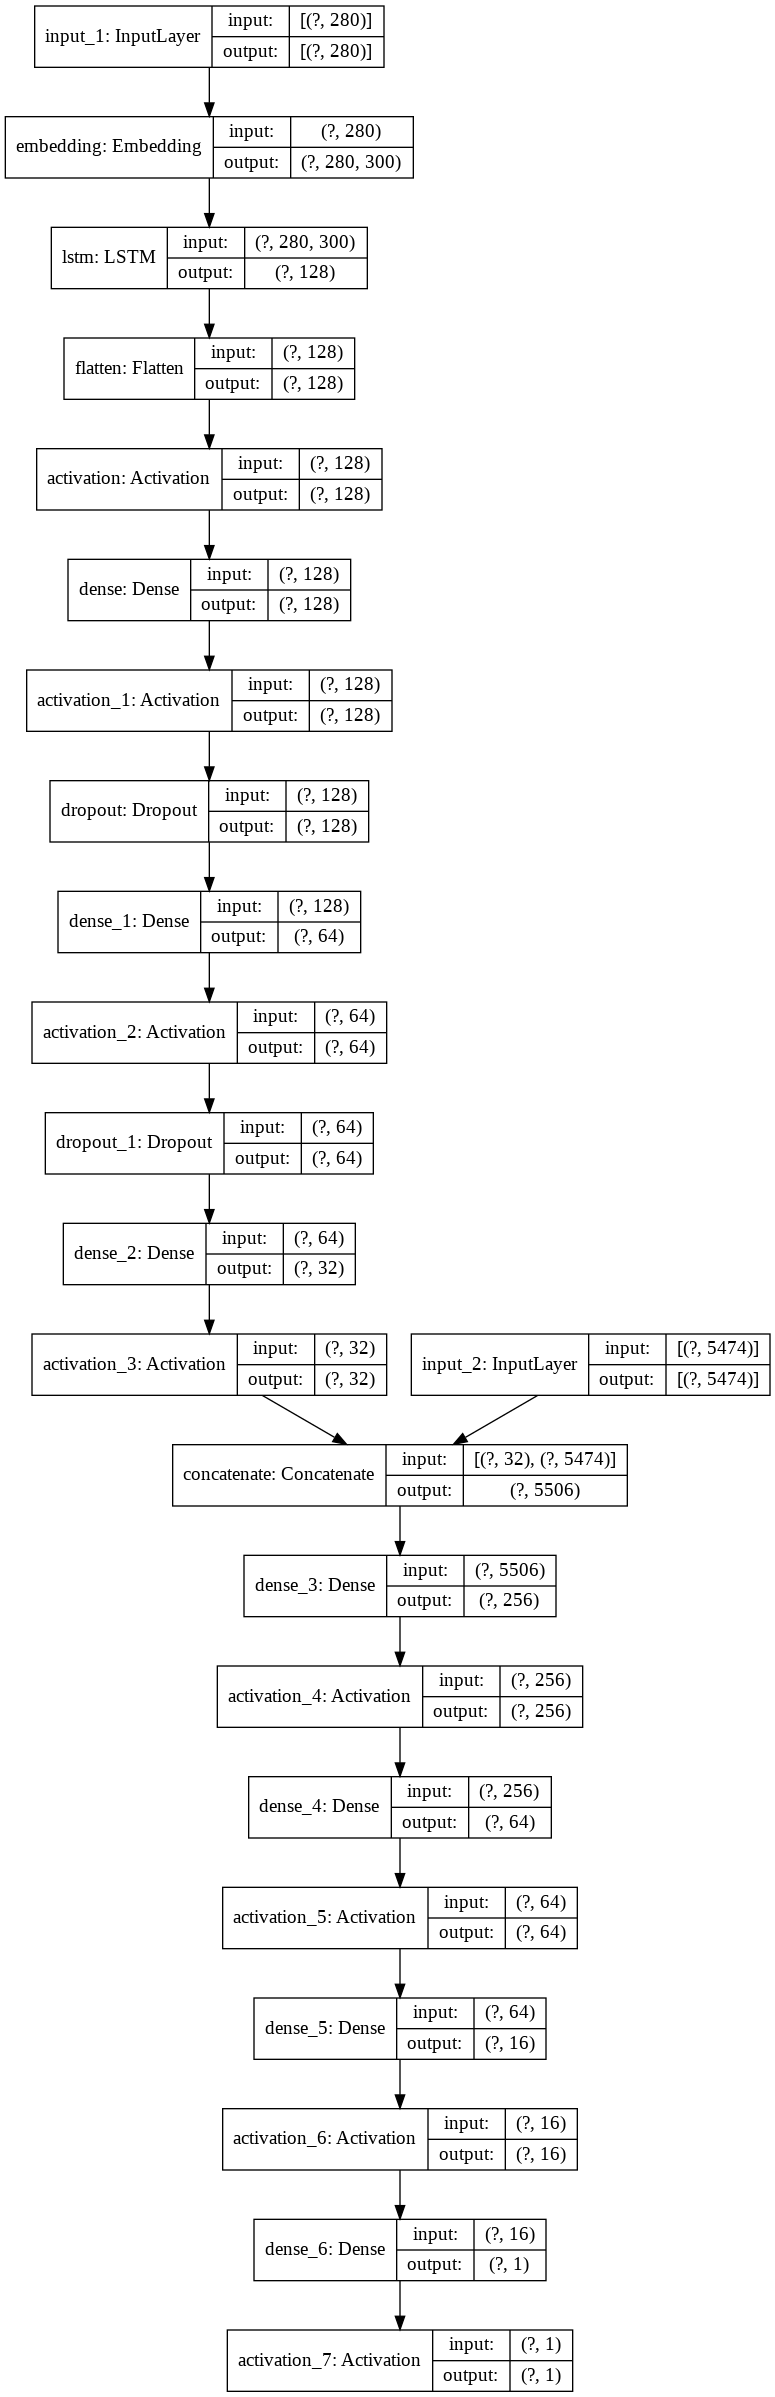

In [ ]:
tf.keras.utils.plot_model(model_1, show_shapes = True, to_file='model.png')

In [ ]:
model_1.fit([X_train_text_temp,X_train],
            y_train,
            batch_size=128,
            validation_data=([X_test_text_temp, X_test], y_test),
            epochs=10)

Epoch 1/10
8687/8687 [==============================] - 349s 40ms/step - loss: 0.3631 - rmsle: 0.5968 - val_loss: 0.3375 - val_rmsle: 0.5785
Epoch 2/10
8687/8687 [==============================] - 349s 40ms/step - loss: 0.3408 - rmsle: 0.5814 - val_loss: 0.3547 - val_rmsle: 0.5930
Epoch 3/10
8687/8687 [==============================] - 349s 40ms/step - loss: 0.3385 - rmsle: 0.5783 - val_loss: 0.3355 - val_rmsle: 0.5767
Epoch 4/10
8687/8687 [==============================] - 351s 40ms/step - loss: 0.3334 - rmsle: 0.5750 - val_loss: 0.3361 - val_rmsle: 0.5773
Epoch 5/10
8687/8687 [==============================] - 351s 40ms/step - loss: 0.3358 - rmsle: 0.5738 - val_loss: 0.3383 - val_rmsle: 0.5791
Epoch 6/10
8687/8687 [==============================] - 349s 40ms/step - loss: 0.3313 - rmsle: 0.5722 - val_loss: 0.3425 - val_rmsle: 0.5831
Epoch 7/10
8687/8687 [==============================] - 348s 40ms/step - loss: 0.3291 - rmsle: 0.5711 - val_loss: 0.3284 - val_rmsle: 0.5707
Epoch 8/10
86

I tried using **Conv1D** in this case but the **score** just **wouldn't improve**. This is the best possible score I could achieve with word embeddings. This structure is somewhat **similar** to that of the **research paper** as mentioned in the **related works**. The score wouldn't improve **beyond 0.56** even with more number of epochs. So just like the ML models, the **W2V type of features** are just of **no use** with this type of dataset and so let's see how it performs with MLP.

### 3.2.5. MLP

#### 3.2.5.1. Import data

In [2]:
X_train,X_train_text,y_train,y_train_trans,X_test,X_test_text,y_test,y_test_trans,X_final_test,X_final_test_text = pickle.load(open('dataset_1.pkl', 'rb'))

#### 3.2.5.2. Text Data (TFIDF)

Over here I have considered of **one gram** for **TFIDF** since it helped me get the best score possible.

In [3]:
vectorizer_tfidf = TfidfVectorizer(min_df=10, ngram_range = (1,1))
vectorizer_tfidf.fit(X_train_text)

X_train_essay_tfidf = vectorizer_tfidf.transform(X_train_text)
X_test_essay_tfidf = vectorizer_tfidf.transform(X_test_text)
X_final_test_essay_tfidf = vectorizer_tfidf.transform(X_final_test_text)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train_trans.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print(X_final_test_essay_tfidf.shape)

After vectorizations
(1111901, 23653) (1111901,)
(370634, 23653) (370634,)
(3460725, 23653)


In [4]:
pickle.dump(vectorizer_tfidf,open('/content/drive/My Drive/mercari data/feature_mlp.pkl','wb'))

In [5]:
X_train = hstack((X_train,X_train_essay_tfidf)).tocsr().astype('float32')
del X_train_essay_tfidf
X_test = hstack((X_test,X_test_essay_tfidf)).tocsr().astype('float32')
del X_test_essay_tfidf
X_final_test = hstack((X_final_test,X_final_test_essay_tfidf)).tocsr().astype('float32')

In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_final_test.shape)

(1111901, 29127) (1111901,)
(370634, 29127) (370634,)
(3460725, 29127)


#### 3.2.5.3. Modelling

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Embedding, Reshape, Concatenate, Dropout, concatenate
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras import applications, Input
import random as rn

In [8]:
tf.keras.backend.clear_session()
np.random.seed(0)
rn.seed(0)

model_in = Input(shape=(X_train.shape[1],), sparse=True)
out = Dense(512, kernel_initializer='normal')(model_in)
out = Activation('relu')(out)
out = Dense(128, kernel_initializer='normal')(out)
out = Activation('relu')(out)
out = Dense(32, kernel_initializer='normal')(out)
out = Activation('relu')(out)
out = Dense(8, kernel_initializer='normal')(out)
out = Activation('relu')(out)
out = Dense(1, kernel_initializer='normal')(out)
out = Activation('linear')(out)
model_1 = Model(model_in, out)
model_1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29127)]           0         
_________________________________________________________________
dense (Dense)                (None, 512)               14913536  
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
activation_2 (Activation)    (None, 32)               

In [9]:
def rmsle_score(actual, predicted):
  return np.sqrt(np.nansum(np.square(np.log(predicted+1) - np.log(actual+1)))/float(len(actual)))

def rmsle(y_true, y_pred):
    return tf.py_function(rmsle_score, (y_true, y_pred), tf.double)

In [10]:
model_1.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0005),
                loss=tf.keras.losses.MeanSquaredLogarithmicError(),
                metrics = [rmsle])

In [11]:
model_1.fit(X_train,
            y_train,
            batch_size=8,
            validation_data=(X_test, y_test),
            epochs=4)

Epoch 1/4
138988/138988 [==============================] - 788s 6ms/step - loss: 0.2410 - rmsle: 0.4610 - val_loss: 0.2118 - val_rmsle: 0.4347
Epoch 2/4
138988/138988 [==============================] - 794s 6ms/step - loss: 0.1903 - rmsle: 0.4106 - val_loss: 0.2011 - val_rmsle: 0.4229
Epoch 3/4
138988/138988 [==============================] - 794s 6ms/step - loss: 0.1658 - rmsle: 0.3820 - val_loss: 0.1960 - val_rmsle: 0.4170
Epoch 4/4
138988/138988 [==============================] - 792s 6ms/step - loss: 0.1461 - rmsle: 0.3574 - val_loss: 0.1969 - val_rmsle: 0.4175


Although I forgot to print the test rmsle score over here, I have printed in the section "4. Final predictions". Even if there is a **slight overfit** out here, this model gave me the **best rank possible** on kaggle and bumped up my rank to the **top 15% of the leaderboard**.

In [12]:
# serialize model to JSON
model_json = model_1.to_json()
with open("/content/drive/MyDrive/mercari data/mlp_model.json", "w") as json_file:
    json_file.write(model_json)

In [13]:
# serialize weights to HDF5
model_1.save_weights("/content/drive/MyDrive/mercari data/mlp_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
#Saving the predicted outputs for ensembling
mlp_predicted = model_1.predict(X_test)
file = '/content/drive/MyDrive/mercari data/y_mlp.npy'
np.save(file,mlp_predicted)
mlp_predicted = model_1.predict(X_final_test)
file = '/content/drive/MyDrive/mercari data/y_mlp_final.npy'
np.save(file,mlp_predicted)

# 4. Final predictions

Since **one of the related works** had **ensembling** used in them, let's try it out and see whether the score improves any further.

In [ ]:
_,_,_,_,_,_,y_test,_,_,_ = pickle.load(open('dataset_1.pkl', 'rb'))
del _

In [ ]:
# Loading the predicted outputs of the models which performed best so far

file = '/content/drive/MyDrive/mercari data/y_mlp.npy'
y_1 = np.load(file)
file = '/content/drive/MyDrive/mercari data/y_ridge.npy'
y_2 = np.load(file)
file = '/content/drive/MyDrive/mercari data/y_lgbm.npy'
y_3 = np.load(file)

file = '/content/drive/MyDrive/mercari data/y_mlp_final.npy'
y_1_final = np.load(file)
file = '/content/drive/MyDrive/mercari data/y_ridge_final.npy'
y_2_final = np.load(file)
file = '/content/drive/MyDrive/mercari data/y_lgbm_final.npy'
y_3_final = np.load(file)

In [ ]:
#Resizing the MLP outputs
temp = []

for i in y_1:
  for j in i:
    temp.append(j)

y_1 = np.array(temp)
del temp

In [ ]:
def rmsle_score(actual, predicted):
  sum = 0
  for i in range(actual.shape[0]):
    sum = sum + np.square(np.log(predicted[i]+1) - np.log(actual[i]+1))
  msle = sum/actual.shape[0]
  return np.sqrt(msle)

In [ ]:
# Printing the test RMSLE score with respect to MLP
rmsle_score(y_test,y_1)

0.44451786833981005

In [ ]:
# Printing the test RMSLE score with respect to Ridge Regressor
rmsle_score(y_test,y_2)

0.48611086563382827

In [ ]:
# Printing the test RMSLE score with respect to LGBM Regressor
rmsle_score(y_test,y_3)

0.4696213418183347

In [ ]:
# Trying out all the values between 0 and 1 with an interval of 0.05
alpha = beta = gamma = list(np.round(np.arange(0,1,0.05),2))
# Best score is with respect to MLP since it was the best
best_score = 0.4445
best_alpha = 0
best_beta = 0
best_gamma = 0

for a in tqdm(alpha):
  for b in beta:
    for c in gamma:
      y_temp = y_1*a + y_2*b + y_3*c
      score = rmsle_score(y_test, y_temp)
      if score < best_score:
        best_score = score
        best_alpha = a
        best_beta = b
        best_gamma = c

100%|██████████| 20/20 [4:56:39<00:00, 889.95s/it]


In [ ]:
#Printing out the best RMSLE score after ensembling
best_score

0.4333316528942972

In [ ]:
#Printing out the best coefficient of MLP's test output
best_alpha

0.6

In [ ]:
#Printing out the best coefficient of Ridge Regressor's test output
best_beta

0.1

In [ ]:
#Printing out the best coefficient of LGBM Regressor's test output
best_gamma 

0.3

In [ ]:
#Resizing the MLP outputs of the final submission's csv
temp = []

for i in y_1_final:
  for j in i:
    temp.append(j)

y_1_final = np.array(temp)
del temp

In [ ]:
# Multiplying the best coefficients with the final submission outputs
best_y = best_alpha*y_1_final + best_beta*y_2_final + best_gamma*y_3_final

In [ ]:
final_sub = pd.read_csv('/content/drive/MyDrive/mercari data/sample_submission_stg2.csv')
final_sub['price'] = best_y
final_sub.head()

,test_id,price
0,0,5.934235
1,1,10.196606
2,2,59.051051
3,3,14.604517
4,4,6.874268


In [ ]:
# Saving the csv for it to be submitted to Kaggle
final_sub.to_csv('/content/drive/My Drive/mercari data/final_sub_mlp.csv') 

# 5. Final Conclusions



1.   Even if I did not achieve the best possible score, the missing value **imputations** on **brands** and **categories** made the price predictions very much **interpretable** as we had seen in the heatmaps in EDA. 
2.   **Ridge regressor** worked brilliantly well as took the least possible time to predict and train the prices.
3.   For this type of dataset, the **text features** were **very important** and getting rid of even a single word in the sentence would cost heavily as it would decrease the score drastically as we had experienced with respect to word embeddings in the LSTM model. Eventually the **TFIDF features** work **brilliantly well** as compared the Averaged W2V or TFIF Weighted W2V.
4.   In **MLP**, playing around with the **batch sizes** plays a huge role. **Less** the amount of **batch size** is, **more** the model learns in a **very less time** and within **less number of epochs**.
5.   **Ensembling** helped me get the best score possible as it helped me achieve a rank in the **top 12.5% of the leaderboard**.